In [118]:
from google.colab import drive
drive.mount('/content/drive/')

## **Importing the Libraries**

In [9]:
# --- Utilities ---
import os
import sys
import logging
import random
import json
import math
import subprocess

# --- Libraries for Data Handling ---
import numpy as np
!pip install pandas
import pandas as pd


# --- Visualization Libraries ---
!pip install matplotlib
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns

# --- Machine Learning/Deep Learning Libraries ---
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50V2, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# --- Data Preprocessing & Evaluation Libraries ---
!pip install -U scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# --- Image Processing Libraries ---
!pip install opencv-python
import cv2
from PIL import Image

# --- Dataset/ Zip File Handling/Face Detection ---
from zipfile import ZipFile

# --- Additional Libraries for Specific Tasks ---
from collections import defaultdict

# FROM DUPLICATE CHECKING SECTION
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from cv2 import SIFT_create  # SIFT feature detector for duplicate checking
!pip install tqdm
from tqdm import tqdm  # For progress bar functionality

from sklearn.feature_extraction.image import PatchExtractor
import shutil

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [16]:
# LIST CURRENT WORKING DIRECTORY
!pwd

/home/myceliummind


In [35]:
# RESET FOLDERS TO BASE FOR NEW RUN

In [36]:
!rm -r "/tf/notebooks/adjusted_histogram"
!rm -r "/tf/notebooks/content"
!rm -r "/tf/notebooks/clustering_removed"
!rm -r "/tf/notebooks/path"
!rm -r "/tf/notebooks/duplicates_removed"
!rm -r "/tf/notebooks/removed_histogram"
!rm -r "/tf/notebooks/removed_duplicates_log.csv"
!rm -r "/tf/notebooks/adjusted_histogram_log.csv"
!rm -r "/tf/notebooks/found_pairs"

rm: cannot remove '/tf/notebooks/adjusted_histogram': No such file or directory
rm: cannot remove '/tf/notebooks/clustering_removed': No such file or directory
rm: cannot remove '/tf/notebooks/path': No such file or directory
rm: cannot remove '/tf/notebooks/removed_histogram': No such file or directory
rm: cannot remove '/tf/notebooks/removed_duplicates_log.csv': No such file or directory
rm: cannot remove '/tf/notebooks/adjusted_histogram_log.csv': No such file or directory


### **Let us load and unzip the data**

**Note:**
- You must download the dataset from the link provided on Olympus and upload the same on your Google drive before executing the code in the next cell.
- In case of any error, please make sure that the path of the file is correct as the path may be different for you.

In [37]:
# ---------------------------------------------------
# -------------    COLAB ONLINE ONLY  --------------
# ---------------------------------------------------
# Sets the Capstone folder for easy reference
#capstone_folder = '/content/drive/My Drive/Capstone'
#root_path = '/content/'


# Points zip_path to location of the original unaltered zip file
#zip_path = '/content/drive/MyDrive/Capstone/base_zip_file/Facial_emotion_images.zip'

# Sets extraction path in Colab, not Google Drive
#extract_path = '/content/dataset/'

# Unzips the file to the extract_path set above
#with ZipFile(zip_path, 'r') as zip_ref:
    #zip_ref.extractall(extract_path)

# Define the dataset path the folder where the images have been extracted
#dataset_path = '/content/dataset/Facial_emotion_images'

# Define Subsets & Classes
#subsets = ['train', 'validation', 'test']
#classes = ['happy', 'sad', 'surprise', 'neutral']

#print(f'Zip File "Facial_emotion_images.zip" extracted locally to collab at "/content/dataset/"')
#print()
#print(f'capstone_folder = "/content/drive/My Drive/Capstone"')
#print(f'Dataset Path: {extract_path}')
#print(f'Subsets: "train", "validation", and "test" initialized')

#--------------------------------------------------------------
# ---------   JUPYTER NOTEBOOK ONLY   ------------------------
#--------------------------------------------------------------
zip_path = '/tf/notebooks/Facial_emotion_images.zip'
extract_path = '/tf/notebooks/content/dataset/'
root_path = '/tf/notebooks/'

# Unzips the file from paths set in first "Mounting Drive" step
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

Files extracted to: /tf/notebooks/content/dataset/


In [38]:
# **DEFINE PATHS**

In [39]:
# Define Subsets & Classes
subsets = ['train', 'validation', 'test']
classes = ['happy', 'sad', 'surprise', 'neutral']

# Define
dataset_path = os.path.join(root_path, 'content', 'dataset', 'Facial_emotion_images')

# Configures logging for file removal steps
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

## **Visualizing our Classes**

Let's look at our classes.

**Write down your observation for each class. What do you think can be a unique feature of each emotion, that separates it from the remaining classes?**

In [26]:
def visualize_dataset(subset, class_name, n_images=20):
    """
    Visualizes a random subset of images for a specified class from the dataset.

    Parameters:
    - subset: The subset of the dataset to visualize ('train', 'test', 'validation').
    - class_name: The class within the subset to visualize (e.g., 'happy', 'sad').
    - n_images: The number of images to display, with a default of 20.
    """
    # path to the subset directory (e.g., 'train', 'test')
    subset_dir = os.path.join(dataset_path, subset)

    # Class Directory path
    class_dir = os.path.join(subset_dir, class_name)

    # Checks if the class directory exists; if not, prints  error message & exits
    if not os.path.exists(class_dir):
        print(f"Directory doesn't exist: {class_dir}")
        return

    # List all files in the class directory, excluding hidden files
    image_files = [file for file in os.listdir(class_dir) if not file.startswith('.')]

    # Randomly shuffles images
    random.shuffle(image_files)

    # Limits the list to the specified number of images (n_images)
    image_files = image_files[:n_images]

    # Calculate the number of rows needed to display the images, with no more than 10 images per row
    n_rows = np.ceil(len(image_files) / 10).astype(int)

    # Determine the number of columns for the subplot grid, capped at 10
    n_cols = min(len(image_files), 10)

    # Initialize a matplotlib figure with dynamically adjusted size based on the number of rows
    plt.figure(figsize=(15, 2 * n_rows))

    # Title for the figure, capitalizing the class name and subset for readability
    plt.suptitle(f"{class_name.capitalize()} - {subset.capitalize()}")

    # Loop through the selected image files for display
    for i, image_file in enumerate(image_files):
        # Construct the full path to the image file
        img_path = os.path.join(class_dir, image_file)

        # Open the image file using PIL and ensure it's in the correct format
        img = Image.open(img_path)

        # Create a subplot for each image in the grid
        ax = plt.subplot(n_rows, n_cols, i + 1)

        # Display the image, using a grayscale colormap if the image is in grayscale format
        plt.imshow(img, cmap='gray' if img.mode == 'L' else None)

        # Set the title of each subplot to the image file's name, with a smaller font size for clarity
        plt.title(image_file, fontsize=8)

        # Remove the axis labels to focus on the images themselves
        plt.axis('off')

    # Adjust the layout to prevent overlap and ensure everything is clearly visible
    plt.tight_layout()

    # Display the entire figure with the images
    plt.show()

# DELETE MISLABELED OR NON-FACE IMAGE ALGORITHM

class ImageDeleter:
    # Initialize the class with paths for the dataset and the deletion history file.
    def __init__(self, dataset_path, history_path='deletion_history.json'):
        self.dataset_path = dataset_path  # Store the dataset path.
        self.history_path = history_path  # Specify the file path for saving deletion history.
        # Load the deletion history from a file, or start with an empty history if the file doesn't exist.
        self.deleted_files_history = self.load_deletion_history()

    # Load the deletion history from a JSON file, or initialize an empty history if the file is not found.
    def load_deletion_history(self):
        try:
            with open(self.history_path, 'r') as file:
                # Load the history from the file if it exists.
                history_data = json.load(file)
                # Convert the loaded history back into a defaultdict(list) to ensure
                # that new keys automatically have an associated list.
                history_defaultdict = defaultdict(list, history_data)
                return history_defaultdict
        except (FileNotFoundError, json.JSONDecodeError):
            # Return an empty history if the file doesn't exist or if there's an error reading it.
            return defaultdict(list)

    # Save the current state of the deletion history to a JSON file.
    def save_deletion_history(self):
        with open(self.history_path, 'w') as file:
            # Convert the defaultdict to a regular dictionary for JSON serialization.
            history_dict = dict(self.deleted_files_history)
            # Write the history to the file.
            json.dump(history_dict, file, indent=4)

    # Delete an image by its number and automatically print the updated deletion history.
    def delete_image_by_number(self, image_number):
        # Traverse the directory structure of the dataset.
        for root, dirs, files in os.walk(self.dataset_path):
            for file in files:
                # Check if the file is an image.
                if file.endswith(".jpg") or file.endswith(".png"):
                    # Extract the file number from the filename.
                    file_number = os.path.splitext(file)[0]
                    # If the file number matches the target, delete the file.
                    if file_number == str(image_number):
                        file_path = os.path.join(root, file)
                        os.remove(file_path)  # Delete the file.
                        # Record the deletion in the history.
                        self.deleted_files_history[root].append(file)
                        # Immediately save the updated history to file.
                        self.save_deletion_history()
                        # Print a confirmation message.
                        print(f"Deleted image {file} in folder {root}")
                        # After each deletion, print the entire deletion history.
                        self.print_deleted_files_history()
                        return  # Exit after finding and deleting the image to avoid unnecessary processing.
        print(f"Image number {image_number} not found.")  # Notify if the image was not found.

    # Print the history of deleted files.
    def print_deleted_files_history(self):
        print("Deleted Files History:")
        for folder_path, files in self.deleted_files_history.items():
            print(f"Folder: {folder_path}")
            for file_name in files:
                print(f"- {file_name}")
        print("End of History")

# Example usage:
deleter = ImageDeleter("/content/dataset/Facial_emotion_images")

# deletes an image and print the history in one step, call delete_image_by_number with an image number. #, , ,
#Deleter Call    # ENTERED AND READY FOR DELETE AFTER FIRST MODEL RUNS
deleter.delete_image_by_number(22337)
deleter.delete_image_by_number(23784)
deleter.delete_image_by_number(30018)
deleter.delete_image_by_number(12976)
deleter.delete_image_by_number(2792)
deleter.delete_image_by_number(30105)
deleter.delete_image_by_number(9153)
deleter.delete_image_by_number(13776)
deleter.delete_image_by_number(2494)
deleter.delete_image_by_number(27784)
deleter.delete_image_by_number(13818)
deleter.delete_image_by_number(29138)
deleter.delete_image_by_number(12617)
deleter.delete_image_by_number(19960)
deleter.delete_image_by_number(20828)
deleter.delete_image_by_number(10871)
deleter.delete_image_by_number(25117)
deleter.delete_image_by_number(7475)
deleter.delete_image_by_number(34242)
deleter.delete_image_by_number(11346)
deleter.delete_image_by_number(27788)
deleter.delete_image_by_number(27973)
deleter.delete_image_by_number(12677)
deleter.delete_image_by_number(32308)
deleter.delete_image_by_number(29954)
deleter.delete_image_by_number(2803)
deleter.delete_image_by_number(12224)
deleter.delete_image_by_number(23943)
deleter.delete_image_by_number(32968)
deleter.delete_image_by_number(23346)
deleter.delete_image_by_number(15527)
deleter.delete_image_by_number(132)
deleter.delete_image_by_number(69)
deleter.delete_image_by_number(34950)
deleter.delete_image_by_number(915)
deleter.delete_image_by_number(20155)
deleter.delete_image_by_number(15765)
deleter.delete_image_by_number(7435)
deleter.delete_image_by_number(4552)
deleter.delete_image_by_number(11180)
deleter.delete_image_by_number(16570)
deleter.delete_image_by_number(22905)
deleter.delete_image_by_number(22095)
deleter.delete_image_by_number(25952)
deleter.delete_image_by_number(7205)
deleter.delete_image_by_number(1189)
deleter.delete_image_by_number(25320)
deleter.delete_image_by_number(10211)
deleter.delete_image_by_number(31127)
deleter.delete_image_by_number(5264)
deleter.delete_image_by_number(7258)
deleter.delete_image_by_number(9611)
deleter.delete_image_by_number(7401)
deleter.delete_image_by_number(19632)


### **Happy**

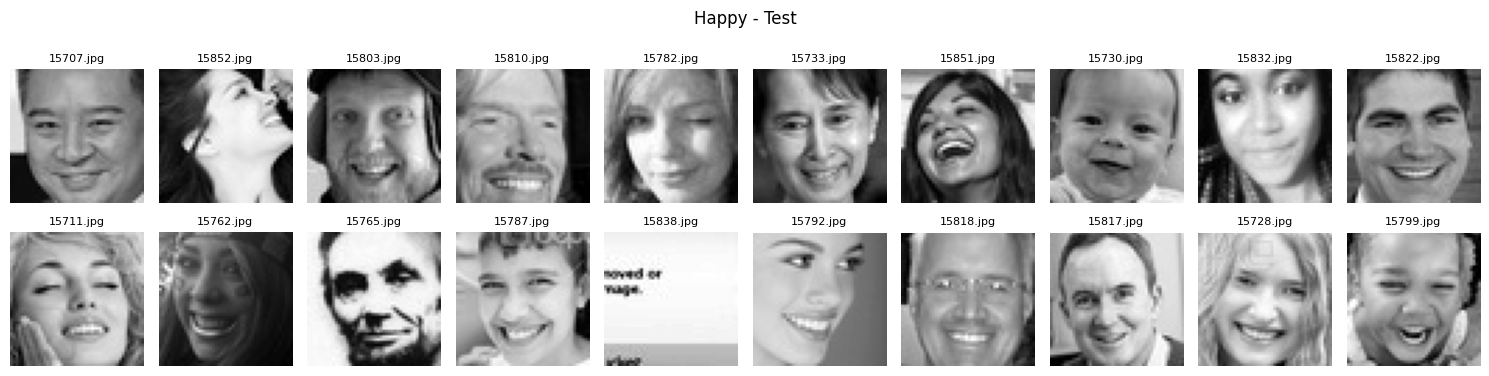

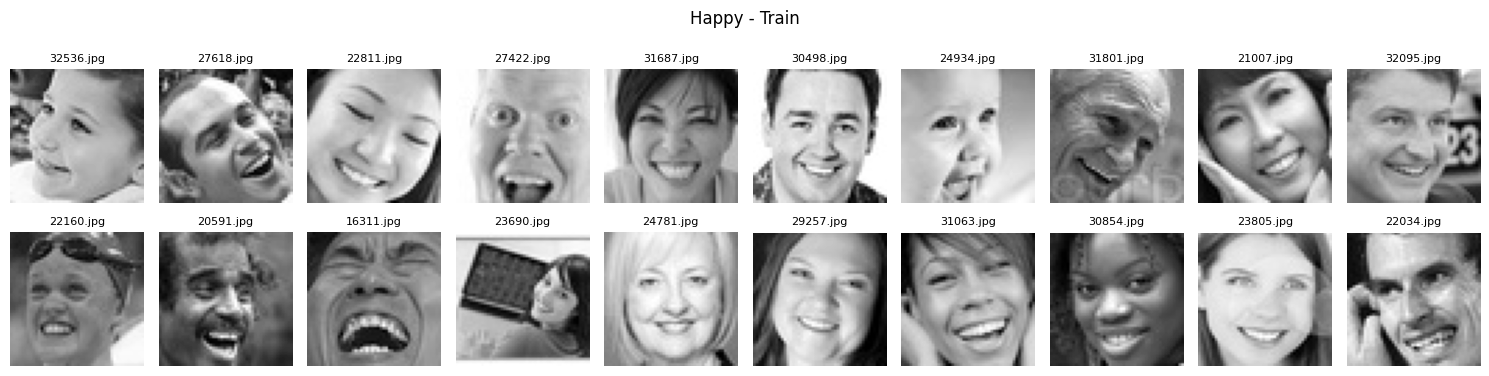

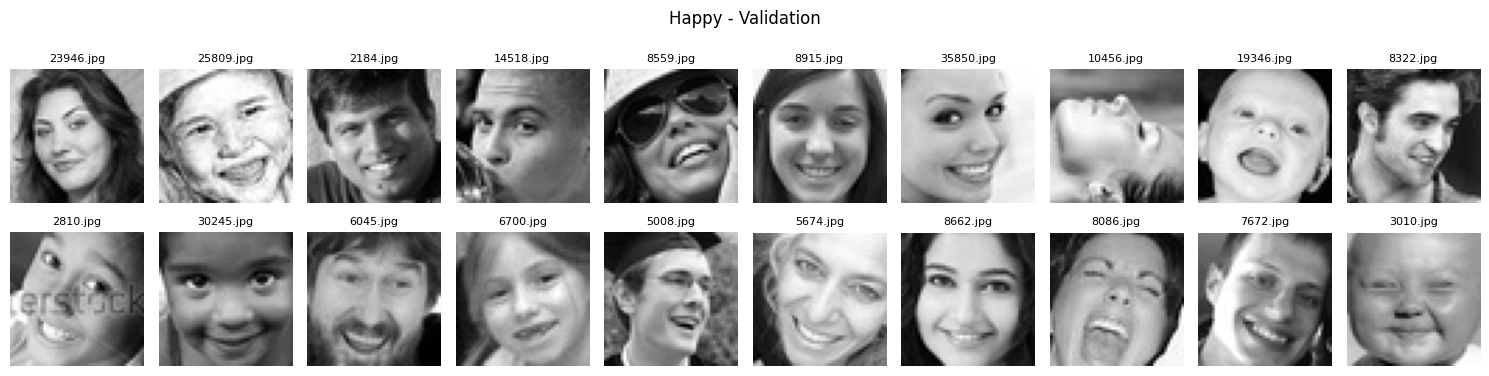

In [40]:
# 20 Random Happy class images from each test/train/validation folders
visualize_dataset('test', 'happy')
visualize_dataset('train', 'happy')
visualize_dataset('validation', 'happy')

**Observations and Insights:**

***Primary Unique Features:***
- Most 'happy' images show wide open or slightly closed smiles, often with teeth visible and lips upturned. Eyes are generally squinted, cheeks full and round with noticeable highlights. Facial muscles appear relaxed and open, with a direct or forward-facing gaze.

**Secondary/Occasional Features**:
- Some images feature raised arms, high arching eyebrows along with open smiling lips showing teeth. A few have heads turned upwards slightly with closed eyes and a closed-lip smile.

**Noise In Class**:
- Several images were identified as not accurately representing 'happy' faces, including those that were mislabeled, blurry, or not images of faces at all. These were removed through a combination of manual inspection and an image removal algorithm, aiming to enhance the dataset's accuracy for training and testing purposes.


### **Sad**

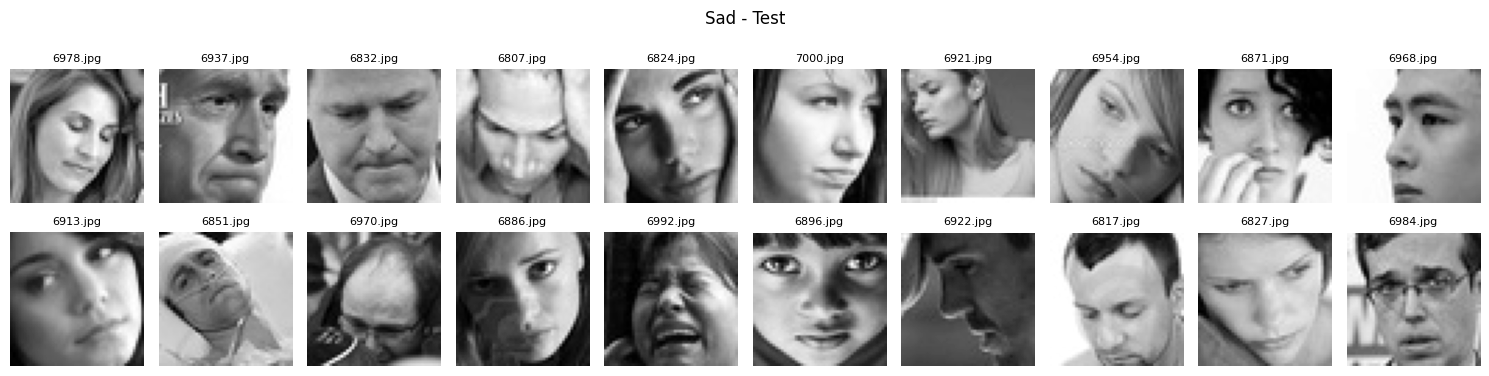

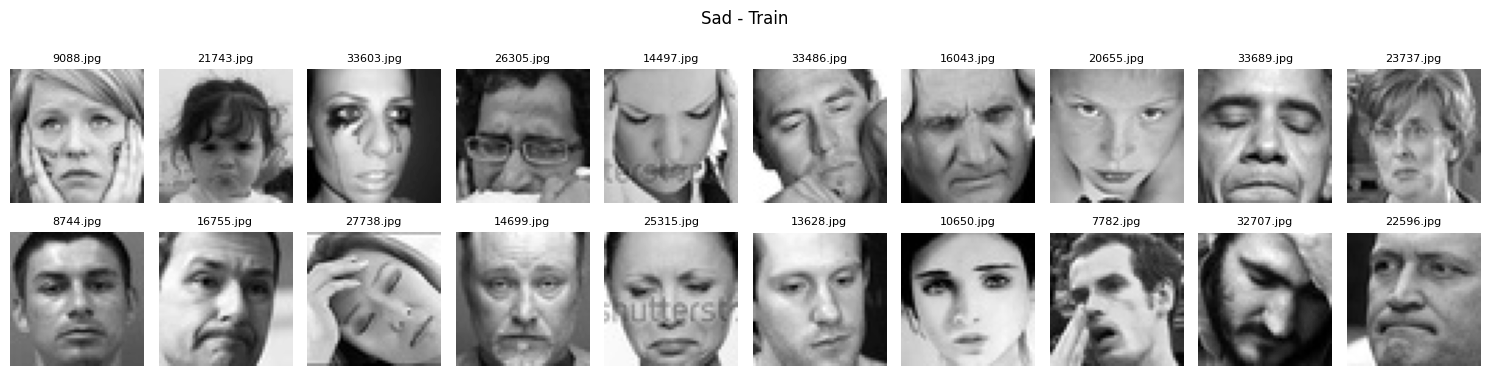

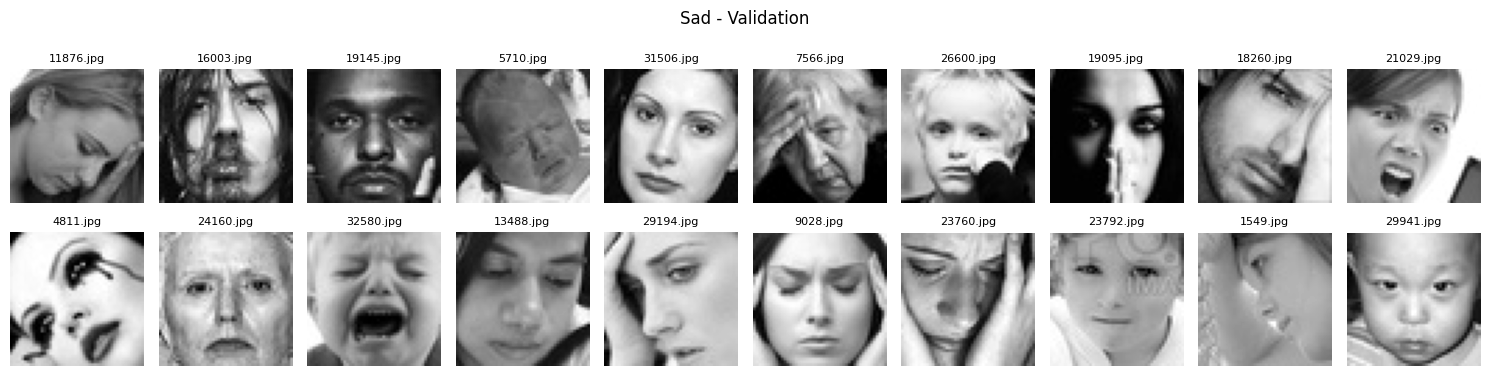

In [41]:
# 20 Random Sad class images from each test/train/validation folders
visualize_dataset( 'test', 'sad')
visualize_dataset('train', 'sad')
visualize_dataset('validation', 'sad')

**Observations and Insights:**

***Primary Unique Features:***
- The majority of samples images of "sad" class in the dataset mostly show heads and eyes are generally turned or looking downward or away. Heads and eyes are generally turned or looking downward or away.
Mouths often have downturned corners of the mouth, mostly with lips closed tightly or slightly parted but without a smile.
- Eyes tend to be open, but not as wide as "happy" images. Eyes generally don't show much whites of the eyes above or below irises. They are often looking down or away (not direct or forward).
- The eyelids are not usually tight and they lack squinting. They are often relaxed and closed/half closed or looking down with the eyebrows often relaxed towards.
- The overall facial muscles/cheeks appears less full compared to "happy" images, with less emphasis on cheek roundness, highlights or dimples as were in the happy datasets. Most generally a lack of muscle tension, often appearing much more relaxed than the Happy dataset in general.

***Secondary/Occasional Features:***
- Some "sad" class images have eyebrows pulled toward center, creating a furrowed downward inner angle or tension to brows.
- A couple of images have tented hands on either side of the face and brow with eyebrows upturned on outer edge.
- A couple others have tentative or folded hands near mouth.
- Images with squinted eyes or open mouths are different from the "happy" class by being more squeezed tightly shut or combination of open mouth with tightly shut eyes.

**Noise in Class:**
- Initial data collection/labeling stages had some mislabeled images. Specifically, in the "train" and "validation" subsets, certain images were not consistent with their assigned emotion labels. For example, the sixth image in the "train" subset and the fourth and seventh images in the "validation" subset were more accurately described as neutral rather than their given labels.

- A number of images within the training set were identified as not fitting their assigned categories. Images labeled as neutral or showing ambiguous emotions, such as those appearing angry when they should be neutral or vice versa, were removed. This included specific images that, upon review, did not clearly fit into the 'happy' category, displaying more neutral expressions or partially obscured faces.

- The cleanup process involved the use of an image deletion function to remove these inaccuracies, aiming to improve the dataset's consistency and reliability for training the model.


### **Neutral**

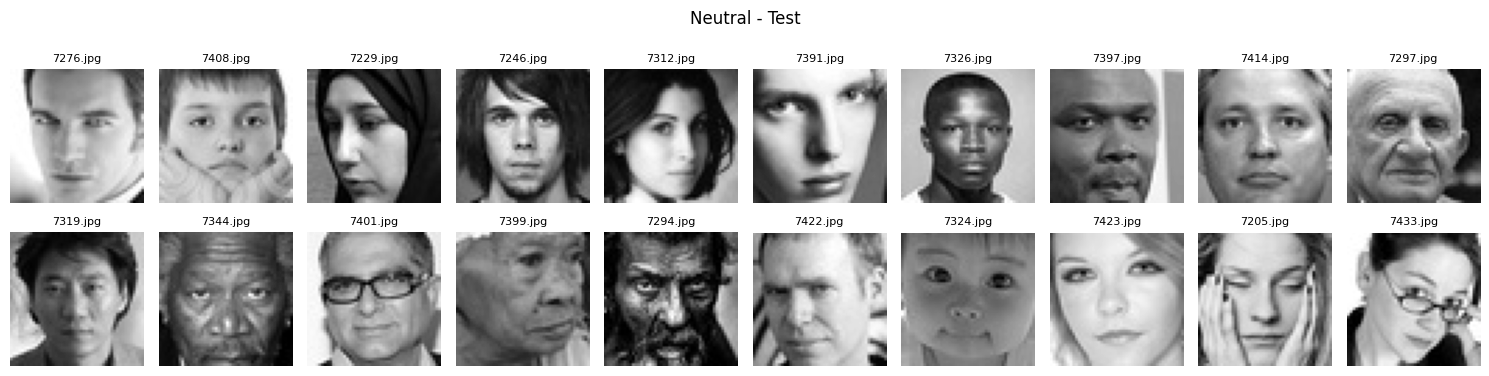

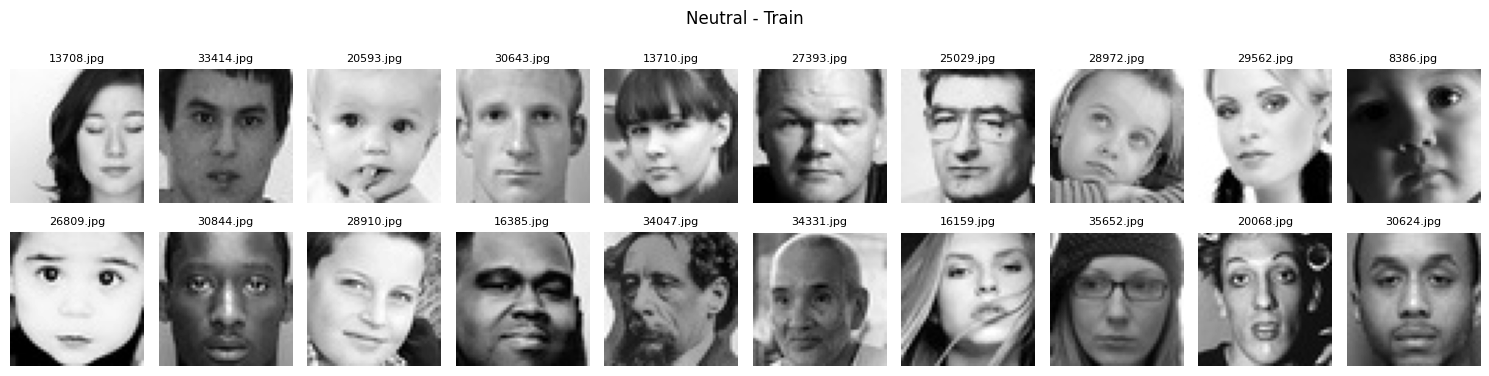

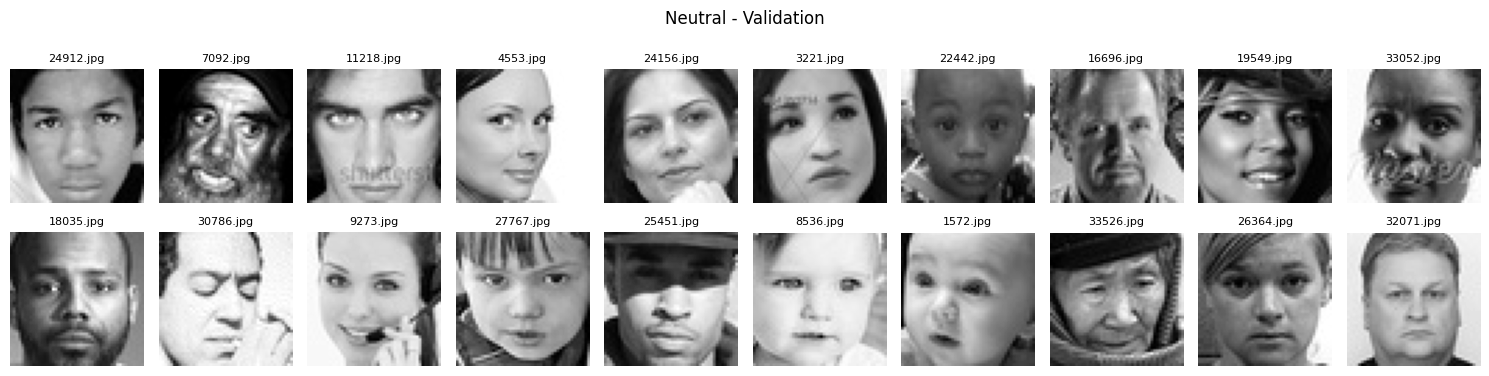

In [42]:
# 20 Random Neutral class images from each test/train/validation folders
visualize_dataset('test', 'neutral')
visualize_dataset('train', 'neutral')
visualize_dataset('validation', 'neutral')

**Observations and Insights:**

***Primary Features:***
- The "Neutral" class image examples generally are show a consistent direct and forward face or eyes that are generally relaxed and often looking at the camera. Eyes generally are not squinted, furrowed, raised or angled.
- Mouths are mostly closed, set in a straight line without the upward or downward curves, and not as wide as the previous two classes.

***Secondary/Occasional Features:***

- When hands are showing, they are relaxed and not tense or tented as in previous classes.
- Some mouths are slightly open, but not widely

**Noise in Class:**

- Some images with closed eyes might be wrongly tagged as neutral when they actually look more sad. Noticed this in the first, fourth, and sixth pics in the test group, plus the seventh and ninth in the "train" bunch and the very last one in the "validation" set.
- There's one pic at the end of the neutral bunch with a smile that's probably in the wrong category. Should be happy, not neutral.
- Found many that were either mislabeled or not faces at all. Pulled them out of the dataset by hand.



### **Surprised**

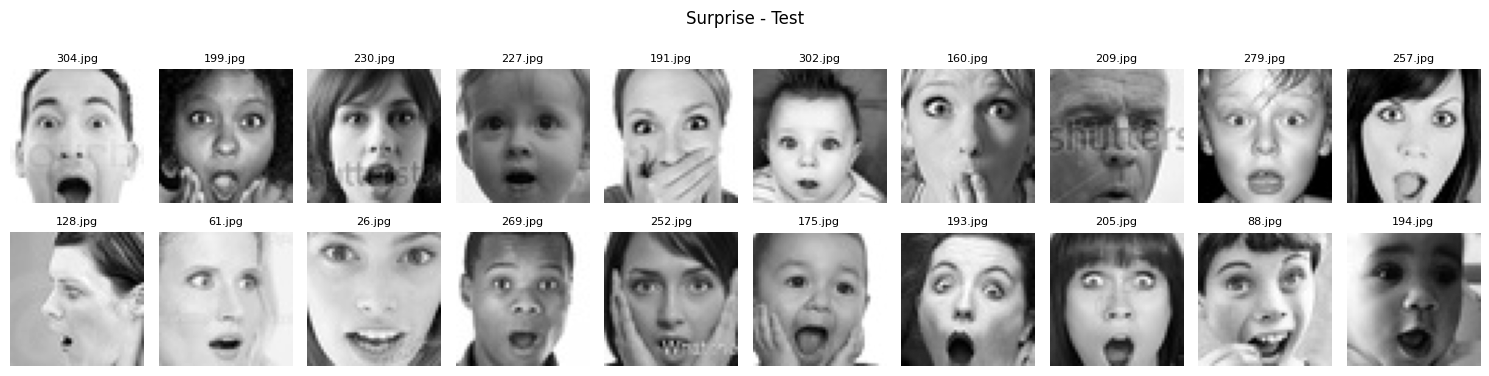

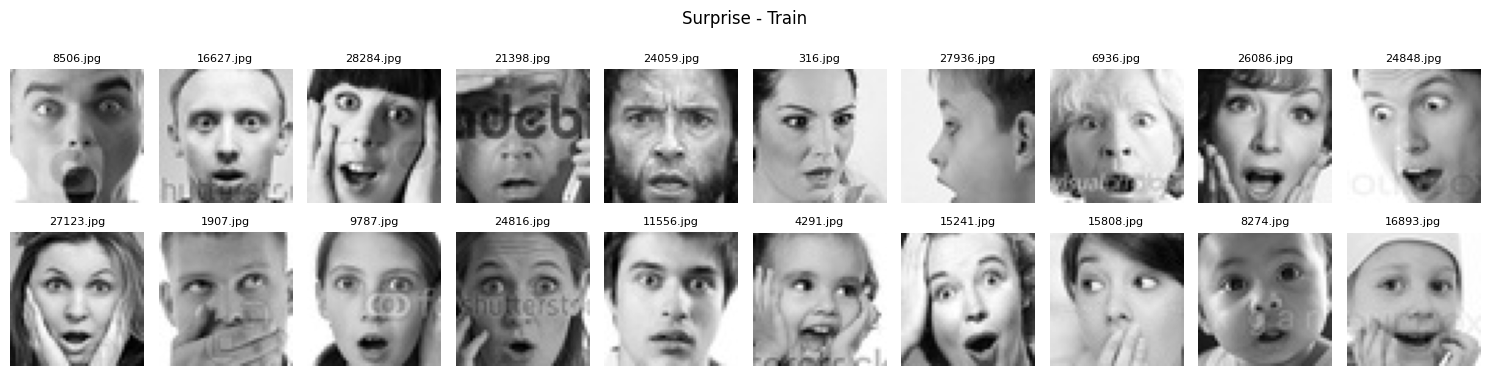

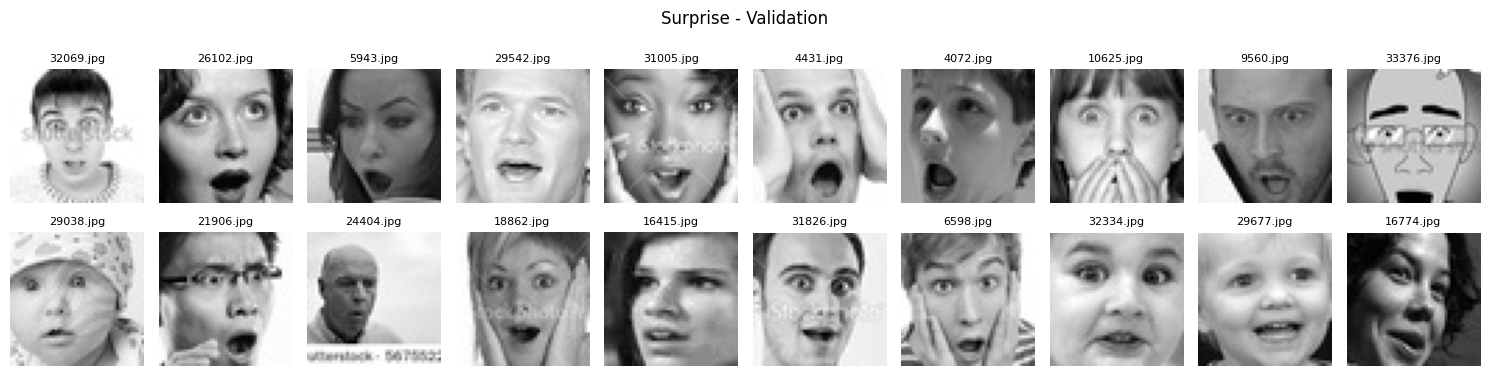

In [43]:
# 20 Random Surprised class images from each test/train/validation folders
visualize_dataset('test', 'surprise')
visualize_dataset('train', 'surprise')
visualize_dataset('validation', 'surprise')

**Observations and Insights:**

***Primary Features:***
- The "Surprise" class images consistently have wideer-open rounder eyes than any other class and raised and arched eyebrows. Whites are often showing above the iris.
- Mouths are frequently open to varying degrees, ranging from slightly parted lips to fully agape, a common physical response to surprising stimuli.
- The facial muscles appear tensed or stretched, especially around the eyes and forehead, intensifying the expression of surprise.

***Secondary/Occasional Features:***
- Hands are sometimes visible and covering the mouth or touching the cheeks.
- The head can be tilted back slightly in some images with flat or tense hands and fingers besides mouth/cheeks (lower than sad) or covering mouth.
- Whites of eyes are sometimes not showing (with smiles) or showing just the underneath. Some show none.
  
***Noise in Class:**
- Maany images didn't exactly fit the "Surprise" category, looking more like they're leaning towards sad or just not that surprised. You've got less of the wide-eyed, mouth agape look and more subdued expressions.
- There are also some that seem mislabeled. Instead of showing surprise, they might be closer to happy, disgusted, or just neutral. It's like they were tagged "Surprise" on a whim.
- Lastly, there's a bit of a mix-up with expressions that could lead to misclassification, where the facial cues don't quite match up with a clear surprise, potentially throwing off the algorithm's learning curve. I removed any ambigous, mislabeled or non-face images from set.


## **Checking INITIAL Distribution of Classes**

train set distribution:
 - happy: 3976
 - sad: 3982
 - surprise: 3173
 - neutral: 3978

validation set distribution:
 - happy: 1825
 - sad: 1139
 - surprise: 797
 - neutral: 1216

test set distribution:
 - happy: 32
 - sad: 32
 - surprise: 32
 - neutral: 32



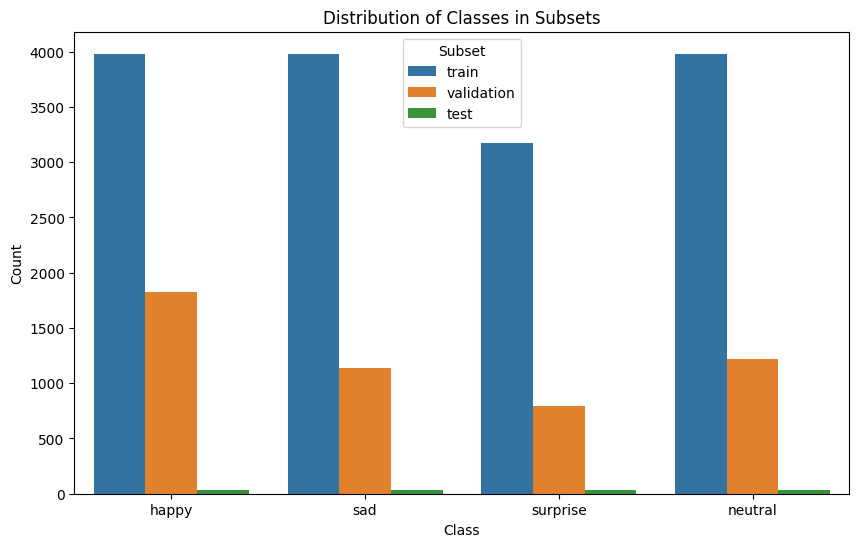

In [44]:
# New dictionary to store counts for each class in each subset
class_counts = {subset: {class_name: 0 for class_name in classes} for subset in subsets}

# New List to store each instance with its subset, class, & count
data_for_visualization = []

# Loop for counting instances & storing data
for subset in subsets:
    for class_name in classes:
        path = os.path.join(dataset_path, subset, class_name)  # Updated path using dataset_path
        count = len(os.listdir(path))
        class_counts[subset][class_name] = count
        data_for_visualization.append((subset, class_name, count))

# Loop for printing counts
for subset, counts in class_counts.items():
    print(f"{subset} set distribution:")
    for class_name, count in counts.items():
        print(f" - {class_name}: {count}")
    print()

# Convert the data for visualization into a DataFrame
df = pd.DataFrame(data_for_visualization, columns=['Subset', 'Class', 'Count'])

# Seaborn count plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Class', y='Count', hue='Subset')
plt.title('Distribution of Classes in Subsets')
plt.show()

**Think About It:**
* Are the classes equally distributed? If not, do you think the imbalance is too high? Will it be a problem as we progress?
* Are there any Exploratory Data Analysis tasks that we can do here? Would they provide any meaningful insights?

**Think About It:**

- Are the classes distributed evenly across the subsets?
- Is the imbalance significant, and could it pose a problem as we progress?
- What Exploratory Data Analysis tasks could we undertake here for meaningful insights?

**Observations and Insights:**

The distribution of classes varies across the subsets, indicating an imbalance.

**OBSERVATIONS:**

- **Training Set:** The 'Happy', 'Sad', and 'Neutral' categories each have a substantial number of images, while the 'Surprise' category has noticeably fewer.
- **Test Set:** This subset shows a more balanced distribution among the classes.
- **Validation Set:** Here, we see the most significant variance in distribution, with 'Happy' having the highest number of images and 'Surprise' the fewest.
- **NON-FACE IMAGES:** During the review of various visualizations, some images were identified that did not feature a face, indicating noise in the dataset from mislabeled images or irrelevant content. Efforts were made to remove these to enhance data quality, despite constraints on time and resources.

**INSIGHTS:**

There's a notable imbalance in the training set, particularly affecting the 'Surprise' category, and a pronounced discrepancy in the validation set between 'Happy' and 'Surprise'. This imbalance could lead to model bias, favoring more represented classes, and potentially impairing performance on less represented classes.

- **Bias in Model:** There's a risk of the model developing a bias towards classes that are more frequently represented.
- **Overfitting:** The majority classes might lead to overfitting, with poorer generalization on minority classes.
- **Performance Metrics:** Standard metrics like accuracy might not fully capture the effects of class imbalance.

**CONCLUSIONS:**

The imbalance, especially notable in the 'Surprise' category within the training set, might lead to model bias and underperformance on this class. This issue warrants attention and possibly corrective measures.

**Exploratory Data Analysis Tasks to Consider:**

- **Label Correction:** Analyzing and correcting mislabeled images could enhance overall model accuracy.
- **Pattern Identification:** Identifying patterns in frequently mislabeled images may inform adjustments in preprocessing or model configuration.
- **Preprocessing Techniques:** Examining pixel intensity distributions or color histograms could reveal if techniques like histogram equalization would benefit model performance.
- **Feature Extraction:** Applying techniques to reduce dimensionality and highlight distinguishing features between classes.
- **Class Separability Analysis:** Using methods like t-SNE or UMAP to visualize class separation in feature space, offering insights into class distinguishability.

**Adjusting for Imbalance:**

- **Implementing Class Weights:** Adjusting model training to emphasize minority classes. I've increased the class weights for the Surpise class in most models.
- **Using Informative Metrics:** Employing metrics like the F1-score or confusion matrices for a clearer view of class imbalances.
- **Data Augmentation:** Enhancing the representation of 'Surprise' through techniques like resampling or generating synthetic samples.
- **Feature Engineering:** Identifying and augmenting specific features unique to minority classes to improve model learning.


# **Detecting & Removing Duplicates/Noise**

# **Defining Duplicate Checker & Remove Functions - Logging & Printing Results**
**This includes functions for checking duplicates and integrating these checks into removal process, w/ enhanced logging & error handling.**

In [46]:
import logging
from tqdm import tqdm
import os
import shutil
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Define the logging class to integrate tqdm with logging
class TqdmLoggingHandler(logging.Handler):
    def __init__(self, level=logging.NOTSET):
        super().__init__(level)

    def emit(self, record):
        try:
            msg = self.format(record)
            tqdm.write(msg)
        except Exception:
            self.handleError(record)

# Configure the logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()
for handler in logger.handlers[:]:
    logger.removeHandler(handler)
logger.addHandler(TqdmLoggingHandler())

# Define root_path and other directories (root_path must be defined elsewhere in the code)
removed_duplicate_dir = os.path.join(root_path, 'duplicates_removed')
found_pairs_dir = os.path.join(root_path, 'found_pairs')

# Ensure directories exist
os.makedirs(removed_duplicate_dir, exist_ok=True)
os.makedirs(found_pairs_dir, exist_ok=True)

# DataFrame for logging duplicate findings
duplicates_log = pd.DataFrame(columns=['Original', 'Duplicate', 'Match_Score'])

# Function to extract SIFT features using pypopsift
def extract_features(image_paths):
    # Initialize SIFT detector
    sift = cv2.SIFT_create()
    features = {}
    for path in tqdm(image_paths, desc='Computing SIFT Descriptors'):
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
        keypoints, descriptors = sift.detectAndCompute(image, None)  # Detect keypoints & compute descriptors
        features[path] = descriptors
    return features

# Optimize match_features function using FLANN-based matcher
def match_features(features):
    # FLANN parameters & matcher initialization
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)  # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    keys = list(features.keys())
    for i, path in enumerate(tqdm(keys, desc='Matching Descriptors')):
        if features[path] is None: continue  # Skip if no descriptors
        for j in range(i+1, len(keys)):
            if features[keys[j]] is None: continue  # Skip if no descriptors
            matches = flann.knnMatch(features[path], features[keys[j]], k=2)
            # Apply ratio test suggested by Lowe in his SIFT paper
            good_matches = [m for m, n in matches if m.distance < 0.7*n.distance]
            if len(good_matches) > 10:  # Threshold to consider duplicates; adjust as needed
                score = np.mean([m.distance for m in good_matches])
                duplicates_log.loc[len(duplicates_log)] = [path, keys[j], score]
                # Save images to the found pairs directory before moving
                pair_dir = os.path.join(found_pairs_dir, f'pair_{len(duplicates_log)}')
                os.makedirs(pair_dir, exist_ok=True)
                shutil.copy(path, os.path.join(pair_dir, os.path.basename(path)))
                shutil.copy(keys[j], os.path.join(pair_dir, os.path.basename(keys[j])))

# Function to move duplicates to a removal directory
def move_duplicates():
    for _, row in duplicates_log.iterrows():
        duplicate_path = row['Duplicate']
        if os.path.exists(duplicate_path):
            try:
                shutil.move(duplicate_path, os.path.join(removed_duplicate_dir, os.path.basename(duplicate_path)))
                logger.info(f"Moved: {duplicate_path}")
            except Exception as e:
                logger.error(f"Error moving {duplicate_path}: {e}")
        else:
            logger.warning(f"File not found and cannot be moved: {duplicate_path}")

# Function to display pairs of images
def display_image_pairs(duplicates_log, num_pairs=5):
    num_pairs = min(num_pairs, len(duplicates_log))  # Do not exceed number of pairs in log
    for _, row in duplicates_log.head(num_pairs).iterrows():
        # Show the pair from the found_pairs_dir, not the original dataset path
        original_img_path = os.path.join(found_pairs_dir, f'pair_{row.name + 1}', os.path.basename(row['Original']))
        duplicate_img_path = os.path.join(found_pairs_dir, f'pair_{row.name + 1}', os.path.basename(row['Duplicate']))
        if os.path.exists(original_img_path) and os.path.exists(duplicate_img_path):
            try:
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                original_img = plt.imread(original_img_path)
                duplicate_img = plt.imread(duplicate_img_path)
                axs[0].imshow(original_img, cmap='gray')
                axs[0].set_title('Original')
                axs[0].axis('off')
                axs[1].imshow(duplicate_img, cmap='gray')
                axs[1].set_title('Duplicate')
                axs[1].axis('off')
                plt.show()
            except Exception as e:
                logger.error(f"Error displaying image pair: {e}")
        else:
            logger.error(f"Image pair cannot be found for display: {row.name + 1}")

# Main execution sequence
dataset_path = os.path.join(root_path, 'content', 'dataset', 'Facial_emotion_images')
image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(dataset_path) for f in filenames if f.endswith(('.jpg', '.jpeg', '.png'))]
features = extract_features(image_paths)  # Extract features
match_features(features)  # Match features to find duplicates
move_duplicates()  # Move detected duplicates

num_pairs_to_display = 30  # Set the number of pairs to display
duplicates_log.to_csv(os.path.join(removed_duplicate_dir, 'duplicates_log.csv'), index=False)  # Save duplicates log

# Log the summary and display image pairs
logger.info(f"Finished processing. Found and moved {len(duplicates_log)} duplicates. Displaying top {num_pairs_to_display} pairs for review.")
display_image_pairs(duplicates_log, num_pairs_to_display)  # Display image pairs

Matching Descriptors:   0%|▎                                                                          | 101/20214 [08:20<27:39:41,  4.95s/it]


KeyboardInterrupt: 

In [25]:
# **PRINT REMOVED IMAGES FOR VISUAL VERIFICATION**

In [64]:
def print_duplicate_images(log_df):
    """
    Prints all images identified as duplicates or removed for having no features, using matplotlib for visualization.
    
    Parameters:
    - log_df (pd.DataFrame): DataFrame containing the log of image removal actions, including subset, class,
                             image name, removal reason, and optionally the path to the original image for duplicates.
                             
    Each row in the DataFrame should represent an action taken on an image, with enough information to locate
    and display the image file.
    """
    
    # Filter the log for duplicate removals and no-feature removals
    duplicates_log = log_df[log_df['Removal_Reason'].str.contains('Duplicate|No features')]
    
    for _, row in duplicates_log.iterrows():
        # Construct the image path from the log entry details
        image_path = os.path.join(dataset_path, row['Subset'], row['Class'], row['Image_Name'])
        
        # Read the image
        image = cv2.imread(image_path)
        if image is not None:
            # Convert BGR to RGB (matplotlib expects RGB)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            plt.imshow(image)
            plt.title(f"{row['Removal_Reason']}: {row['Image_Name']}")
            plt.axis('off')  # Hide axes ticks
            plt.show()
        else:
            print(f"Image not found: {image_path}")

        # If the reason is a duplicate, also show the corresponding duplicate image
        if 'Duplicate' in row['Removal_Reason']:
            # ********NEEDS CHECKING/ADJUSTING:::****
            original_image_path = row.get('Original_Image_Path', None)  # Adjust based on your logging strategy
            if original_image_path:
                original_image = cv2.imread(original_image_path)
                if original_image is not None:
                    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
                    plt.imshow(original_image)
                    plt.title(f"Original of Duplicate: {os.path.basename(original_image_path)}")
                    plt.axis('off')
                    plt.show()
                else:
                    print(f"Original image not found: {original_image_path}")

# **Duplicate Removal Using Hashing & DF Logging**


# **Identifying Outliers by Brightness Histograms**

In [15]:
from skimage.color import rgb2gray
from skimage import exposure, io
import numpy as np
import os
import pandas as pd

# Assuming root_path, dataset_path, and adjusted_log_file_path are defined as per your setup
# Adjusted histogram directory
adjusted_log_file_path = os.path.join(root_path, 'adjusted_histogram_log.csv')
adjusted_histogram_dir = os.path.join(root_path, 'adjusted_histogram')

# Ensure the adjusted histogram directory exists
os.makedirs(adjusted_histogram_dir, exist_ok=True)

def adjust_image_histogram(image_path, dest_dir, clip_limit=0.05, tile_grid_size=(8, 8)): #Adjusted from .03 first run to .05 and added grid size 
    """Adjust the histogram of an image using CLAHE with optimized settings."""
    image = io.imread(image_path)  # Load the image from disk
    
    # Apply Adaptive Histogram Equalization (CLAHE) with optimized settings
    image_adj = exposure.equalize_adapthist(image, clip_limit=clip_limit, kernel_size=tile_grid_size)
    
    # Save the adjusted image
    adjusted_image_path = os.path.join(dest_dir, os.path.basename(image_path))
    io.imsave(adjusted_image_path, (image_adj * 255).astype(np.uint8))  # Convert back to uint8
    
    return adjusted_image_path

def adjust_brightness_histogram(subset, class_name):
    """Adjust brightness and histogram for a given subset and class, logging each adjustment."""
    dir_path = os.path.join(dataset_path, subset, class_name)  # Source directory path
    adjusted_dir = os.path.join(adjusted_histogram_dir, subset, class_name)  # Destination directory
    os.makedirs(adjusted_dir, exist_ok=True)  # Ensure the destination directory exists
    
    # Loop through each file in the directory
    for image_name in os.listdir(dir_path):
        if image_name.startswith('.'): continue  # Skip hidden files
        image_path = os.path.join(dir_path, image_name)  # Full path to the image
        
        # Adjust the image histogram
        adjusted_image_path = adjust_image_histogram(image_path, adjusted_dir)
        
        # Log the adjustment
        adjusted_images_log.loc[len(adjusted_images_log)] = [subset, class_name, image_name, os.path.basename(adjusted_image_path), 'Histogram Equalization']

# Adjusted images log DataFrame initialization (if not already defined)
adjusted_images_log = pd.DataFrame(columns=['Subset', 'Class', 'Original_Image', 'Adjusted_Image', 'Adjustment'])

# Iterate through subsets and classes, adjusting images and logging
for subset in ['train', 'validation', 'test']:
    for class_name in ['happy', 'sad', 'surprise', 'neutral']:
        adjust_brightness_histogram(subset, class_name)

# Save the log to a CSV file
adjusted_images_log.to_csv(adjusted_log_file_path, index=False)

# Print summary of adjustments
print("Summary of Histogram Adjustments:")
print(adjusted_images_log.groupby(['Subset', 'Class']).size().reset_index(name='Count').to_string(index=False))


Summary of Histogram Adjustments:
    Subset    Class  Count
      test    happy     32
      test  neutral     32
      test      sad     32
      test surprise     32
     train    happy   3976
     train  neutral   3978
     train      sad   3982
     train surprise   3173
validation    happy   1825
validation  neutral   1216
validation      sad   1139
validation surprise    797


# **Extract Features for Clustering**

In [21]:
def extract_features(image_paths):
    """
    This function extracts features from images for clustering-based outlier detection, using Histogram of Oriented Gradients (HOG)

    Method: Extract HOG features from a list of image paths.

    Args:
        image_paths: List of paths to the images from which features will be extracted.

    Returns:
        A numpy array containing the HOG features for each image.
    """
    features = []  # Initialize a list to store the features of each image

    for img_path in image_paths:
        img = io.imread(img_path)  # Read the image
        img_gray = rgb2gray(img)  # Convert to grayscale (redundant if images are already grayscale)
        # Compute HOG features
        hog_features = hog(img_gray, pixels_per_cell=(16, 16), cells_per_block=(1, 1), feature_vector=True)
        features.append(hog_features)  # Append the features to the list

    return np.array(features)  # Return the features as a numpy array


# **Identifying Outliers Using Unsupervised Learning**

Can use unsupervised learning algorithms (e.g., K-means, DBSCAN) to cluster images based on simple extracted features (e.g., color histograms, edges). Images in very small clusters or are significantly distant from cluster centroids can be flagged as outliers.

In [22]:
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.cluster import DBSCAN
import numpy as np
import os
import pandas as pd

def plot_outliers(outliers):
    """Plot and display outlier images."""
    n = len(outliers)
    if n == 0:
        print("No outliers found.")
        return
    print(f"Plotting {n} outliers...")
    plt.figure(figsize=(20, n * 2))  # Adjust the figure size dynamically based on the number of outliers
    for i, outlier_path in enumerate(outliers, start=1):
        img = imread(outlier_path)
        plt.subplot(1, n, i)
        plt.imshow(img)
        plt.title(f'Outlier {i}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [25]:
def flag_outliers_by_clustering(image_paths, subsets, classes):
    """Flag outliers in images by clustering and move them to a designated directory, then print a summary."""
    global removed_images_log
    total_outliers = 0

    for subset in subsets:
        for class_name in classes:
            class_image_paths = [path for path in image_paths if subset in path and class_name in path]
            if not class_image_paths:
                continue

            features = extract_features(class_image_paths)
            clustering = DBSCAN(eps=3, min_samples=2).fit(features)
            outlier_indices = np.where(clustering.labels_ == -1)[0]
            outliers = [class_image_paths[i] for i in outlier_indices]

            if outliers:
                plot_outliers(outliers)  # Plot outliers

            for outlier_path in outliers:
                removed_img_path = os.path.join(removed_clustering_dir, subset, class_name)
                ensure_dir(removed_img_path)
                move_file(outlier_path, removed_img_path, subset, class_name, 'Clustering Outlier')

            print(f"Subset '{subset}', Class '{class_name}': {len(outliers)} outliers detected and moved.")
            total_outliers += len(outliers)

    print(f"Total outliers detected and moved: {total_outliers}")
    
# Save the log after processing all images
removed_images_log.to_csv(log_file_path, index=False)


In [66]:
# Logging DataFrame for removed images due to being outliers
removed_images_log = pd.DataFrame(columns=['Subset', 'Class', 'Image_Name', 'Removal_Reason'])

# Directories for removed images due to various reasons
removed_duplicate_dir = os.path.join(root_path, 'removed_duplicate')
removed_histogram_dir = os.path.join(root_path, 'removed_histogram')
removed_clustering_dir = os.path.join(root_path, 'removed_clustering')

# Function to ensure directories exist
def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Ensure directories for logging and saving removed images are created
ensure_dir(removed_duplicate_dir)
ensure_dir(removed_histogram_dir)
ensure_dir(removed_clustering_dir)

# Log file path for removed images
log_file_path = os.path.join(root_path, 'removed_images_log.csv')

## **Check Distribution 2nd Time After Removing Duplicates & Outliers**

## **Creating our Data Loaders**

In this section, we are creating data loaders that we will use as inputs to our Neural Network.

**You have two options for the color_mode. You can set it to color_mode = 'rgb' or color_mode = 'grayscale'. You will need to try out both and see for yourself which one gives better performance.**

In [27]:
# Define list of color modes for experiments: 'rgb' for 3-channel color images, 'grayscale' for single-channel images
color_modes = ['rgb', 'grayscale']

# Re-establish target size definition once to maintain consistency across data loaders
set_target_size = (48, 48)

for color_mode in color_modes:
    # Set the input shape based on the color mode: 3 channels for 'rgb', 1 channel for 'grayscale'
    input_shape = (*set_target_size, 3) if color_mode == 'rgb' else (*set_target_size, 1)

    # Initialize ImageDataGenerator for training data with augmentation to introduce variability
    train_datagen = ImageDataGenerator(
        rescale=1./255,          # Normalizes pixel values to [0,1]
        rotation_range=15,       # Rotates images up to 20 degrees
        width_shift_range=0.15,   # Shifts images horizontally by up to 20%
        height_shift_range=0.15,  # Shifts images vertically by up to 20%
        shear_range=0.15,         # Applies shear transformation up to 20%
        zoom_range=0.05,          # Zooms images up to 5% due to images mostly being tightly cropped
        horizontal_flip=False,    # Flips images horizontally
        fill_mode='nearest'      # Uses nearest fill mode for new pixels
    )

    # Initialize ImageDataGenerator without augmentation for validation & test datasets
    test_val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescales pixel values to [0,1]

    # Setup training data loader
    train_generator = train_datagen.flow_from_directory(
        f'{dataset_path}/train',
        target_size=set_target_size,  # Resizes images to specified target size
        batch_size=32,
        color_mode=color_mode,
        class_mode='categorical'
    )

    # Setup validation data loader
    validation_generator = test_val_datagen.flow_from_directory(
        f'{dataset_path}/validation',
        target_size=set_target_size,  # Resizes images to specified target size
        batch_size=32,
        color_mode=color_mode,
        class_mode='categorical'
    )

    # Setup test data loader
    test_generator = test_val_datagen.flow_from_directory(
        f'{dataset_path}/test',
        target_size=set_target_size,  # Resizes images to specified target size
        batch_size=32,
        color_mode=color_mode,
        class_mode='categorical',
        shuffle=False  # Maintains order for consistent evaluation
    )

    # Learning rate reduction setup
    lr_reduction = ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1
    )

    # Fetch a batch of images and labels to confirm setup correctness
    images, labels = next(train_generator)
    print(f"Batch shape for {color_mode} images:", images.shape)


Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.
Batch shape for rgb images: (32, 48, 48, 3)
Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.
Batch shape for grayscale images: (32, 48, 48, 1)


## **Model Building**

**Think About It:**
* Are Convolutional Neural Networks the right approach? Should we have gone with Artificial Neural Networks instead?
* What are the advantages of CNNs over ANNs and are they applicable here?

***ANSWER***: CNNs are the right approach over ANNs because they are very good for tasks like facial expression recognition because they are better at intuitively learning and determining spatial features in images. They don't need as many paramaters compared with ANNs, allowing improved efficiency and reduces overfitting. Because they can more easily understand complex visual cues, they're the best choice for identifying emotions through facial expressions most accurately.

### **Creating Base Neural Network**

In [33]:
# SECOND VERSION OF base_cnn:"base_cnn2_model" w/ slightly different architecture

num_classes = 4

# Defines base_cnn2 model architecture & compilation
def create_base_cnn2_model(input_shape, num_classes):
    """
    Define and compile CNN model with updated model.
    Has convolutional blocks with batch normalization and ReLU activation,
    followed by max pooling to reduce dimensionality. Ends with global average pooling
    to minimize overfitting, and fully connected layers for classification.
    """
    model = Sequential([
        # Conv Block 1
        Conv2D(32, (3, 3), padding='same', input_shape=input_shape),  # 32 filters, 3x3 kernel
        BatchNormalization(),  # Normalize activations
        Activation('relu'),  # ReLU activation
        MaxPooling2D((2, 2)),  # Pooling to reduce spatial dimensions

        # Conv Block 2
        Conv2D(64, (3, 3), padding='same'),  # Increase filters to capture more complex features
        BatchNormalization(),  # Normalize activations
        Activation('relu'),  # ReLU activation
        MaxPooling2D((2, 2)),  # Reduce spatial dimensions

        # Conv Block 3
        Conv2D(128, (3, 3), padding='same'),  # Further increase in filters
        BatchNormalization(),  # Normalize activations
        Activation('relu'),  # ReLU activation
        MaxPooling2D((2, 2)),  # Spatial reduction

        # Conv Block 4 - Added for depth
        Conv2D(128, (3, 3), padding='same'),  # Maintaining depth
        BatchNormalization(),  # Normalize activations
        Activation('relu'),  # ReLU activation
        MaxPooling2D((2, 2)),  # Final spatial reduction

        GlobalAveragePooling2D(),  # Global pooling to reduce parameters and focus on global features

        # Fully Connected Layer
        Dense(128, activation='relu'),  # Dense layer for classification
        Dropout(0.3),  # Dropout to combat overfitting

        # Output Layer
        Dense(num_classes, activation='softmax')  # Softmax for multi-class probabilities
    ])

    # Compile model with specifics
    model.compile(optimizer=Adam(learning_rate=0.001),  # Adam optimizer with initial learning rate
                  loss='categorical_crossentropy',  # Suitable for multi-class classification
                  metrics=['accuracy'])  # Tracking accuracy metric

    return model

### **Compiling & Training Base Model**

In [77]:
import json
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Learning rate scheduler function
#def step_decay(epoch):
#    initial_lr = 0.001  # Starting learning rate
#    drop = 0.5  # Learning rate drop factor
#    epochs_drop = 10.0  # Drop the learning rate every 10 epochs
#    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
#    return lr

# Define lr_scheduler callback
#lr_scheduler = LearningRateScheduler(step_decay)

# Define learning rate schedule using ExponentialDecay
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,  # Starting learning rate
    decay_steps=10000,          # Decay step after which learning rate is updated
    decay_rate=0.9              # Decay rate by which learning rate is multiplied
)

# Define optimizer with the learning rate schedule
optimizer = Adam(learning_rate=lr_schedule)

# Define ReduceLROnPlateau for dynamic learning rate adjustments based on validation loss
lr_plateau = ReduceLROnPlateau(
    factor=0.1,        # Factor by which the learning rate will be reduced
    patience=5,        # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.00001,    # Lower bound on the learning rate
    verbose=1          # Print messages when reducing the learning rate
)

# Define target size for image resizing
set_target_size = (48, 48)  # Adjust as per your requirements

# Initialize a dictionary to store the training history for each color mode
base_cnn2_model_history = {}

# Iterate over different color modes for training
color_modes = ['rgb', 'grayscale']
for color_mode in color_modes:
    # Dynamic input shape based on color mode
    input_shape = (*set_target_size, 3) if color_mode == 'rgb' else (*set_target_size, 1)

    # Log current training configuration
    print(f"Training with: {color_mode}, Input shape: {input_shape}")

    # Setup data augmentation for the training dataset
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Setup data normalization for the validation dataset without augmentation
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Prepare the training data loader
    train_generator = train_datagen.flow_from_directory(
        f'{dataset_path}/train',
        target_size=set_target_size,
        batch_size=32,
        class_mode='categorical',
        color_mode=color_mode
    )

    # Prepare the validation data loader
    validation_generator = validation_datagen.flow_from_directory(
        f'{dataset_path}/validation',
        target_size=set_target_size,
        batch_size=32,
        class_mode='categorical',
        color_mode=color_mode
    )

    # Initialize and train the model for the current color mode
    model = create_base_cnn2_model(input_shape, num_classes)
    history = model.fit(
        train_generator,
        epochs=30,
        validation_data=validation_generator,
        callbacks=[lr_plateau],  # Use only lr_plateau as lr_scheduler is not defined
        verbose=1
    )

    # Store the training history
    base_cnn2_model_history[f"base_cnn2_model_{color_mode}"] = history

    # Save the current model
    model.save(f'base_cnn2_model_{color_mode}_keras.h5')   
    model_save_path = f'{root_path}/base_cnn2_model_{color_mode}_keras.h5' # Sets Save Path as Root + Model name
    model.save(model_save_path)  # Calls save method to save the current model after training
    
    # Save The Training History
    history_save_path = f'{root_path}/base_cnn2_model_{color_mode}_history.json'
    # Assuming `history` is the variable holding your model's training history
    with open(f'base_cnn2_model_{color_mode}__history.json', 'w') as f:
    json.dump(history.history, f)
    

Training with: rgb, Input shape: (48, 48, 3)
Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Epoch 1/30
 89/473 [====>.........................] - ETA: 15s - loss: 1.4091 - accuracy: 0.3041

KeyboardInterrupt: 

## SAVE MODEL FOR FUTURE USE
# What gets saved:
- **Model architecture**: The design and configuration of your model, including the types and sequence of layers used.
- **Model weights**: The learned weights of your model, which are crucial for making predictions.
- **Training configuration**: This includes the optimizer and its configuration, necessary for continuing training from where you left off.
- **State of the optimizer**: This allows you to resume training exactly where you left off, which is particularly useful for long training sessions that were interrupted.

In [76]:
# 1. SAVE MODELS IN KERAS FORMAT

# Save KERAS FORMAT
grayscale_base_cnn2_model = create_base_cnn2_model((48, 48, 1), num_classes) # model's expected input size
# Saves the Grayscale model
grayscale_base_cnn2_model.save('base_cnn_model_grayscale_saved')



from tensorflow.keras.models import load_model

# 2. Load Model - can load saved model using load_model function from tensorflow.keras.models
# HDF5 Format:

# Load the model
# model = load_model('my_model.h5')

# SavedModel Format:
# model = load_model('my_saved_model')


# 3. SAVE TO GOOGLE DRIVE

## Save  RGB model to Google Drive
# Saving the RGB model to Google Drive
grayscale_model.save(root_path)

# Saving the Grayscale model to Google Drive


INFO:tensorflow:Assets written to: base_cnn_model_grayscale_saved/assets


2024-02-17 07:29:26,950 - INFO - Assets written to: base_cnn_model_grayscale_saved/assets


INFO:tensorflow:Assets written to: path/to/your/dataset/assets


2024-02-17 07:29:27,683 - INFO - Assets written to: path/to/your/dataset/assets


### **Evaluating the Model on the Test Set**


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
4/4 [==============================] - 0s 8ms/step - loss: 0.5272 - accuracy: 0.7812
Test Loss: 0.5271809697151184
Test Accuracy: 0.78125

4/4 [==============================] - 0s 7ms/step


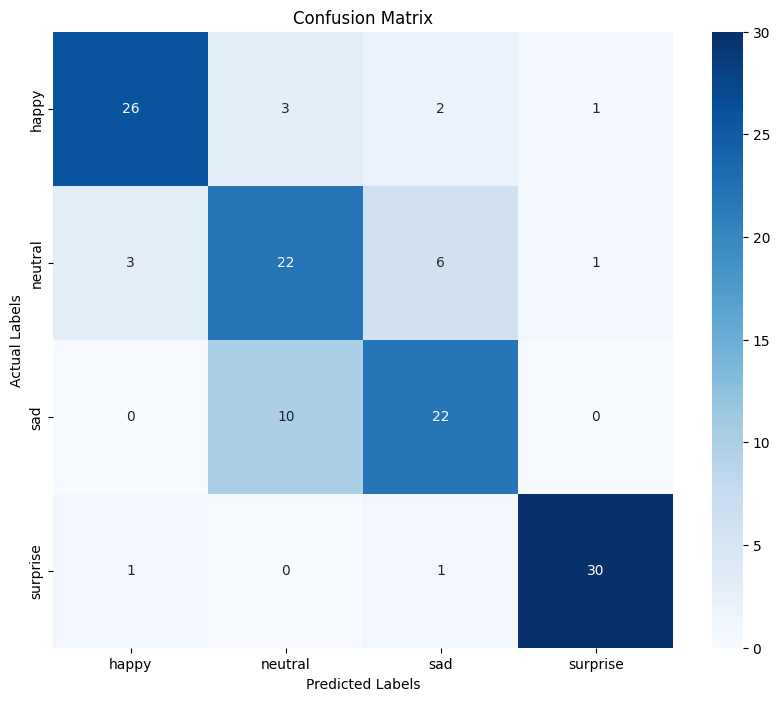

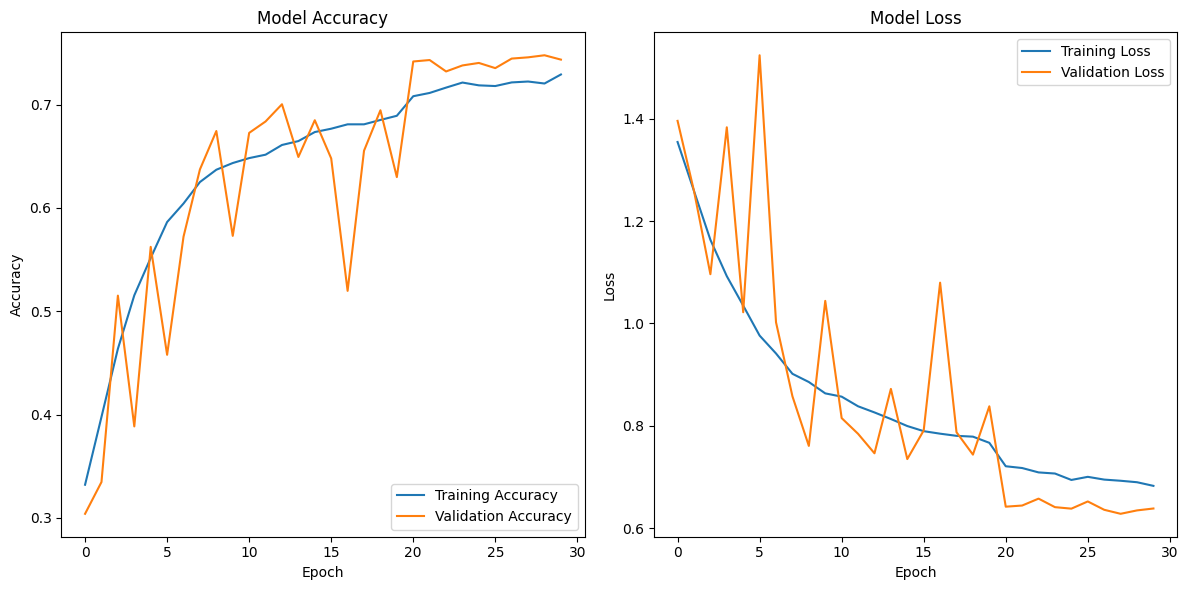

              precision    recall  f1-score   support

       happy       0.87      0.81      0.84        32
     neutral       0.63      0.69      0.66        32
         sad       0.71      0.69      0.70        32
    surprise       0.94      0.94      0.94        32

    accuracy                           0.78       128
   macro avg       0.79      0.78      0.78       128
weighted avg       0.79      0.78      0.78       128



In [60]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib
matplotlib.use('module://ipykernel.pylab.backend_inline')

# Choose the color mode for which you want to evaluate and visualize the model's performance
color_mode = 'rgb'  # or 'grayscale', depending on which model history you want to use

# Access the specific model history from the dictionary using color_mode
history = base_cnn2_model_history[f"base_cnn2_model_{color_mode}"]

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')  # Print the test loss
print(f'Test Accuracy: {test_accuracy}\n')  # Print the test accuracy

# Predict on the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=-1)  # Get the class with the highest probability for each prediction

# Fetch the actual class labels from the test generator
actual_classes = test_generator.classes  # True class labels

# Generate a confusion matrix
cm = confusion_matrix(actual_classes, predicted_classes)  # Compute the confusion matrix

# Visualization of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')  # Title of the confusion matrix
plt.ylabel('Actual Labels')  # Y-axis label
plt.xlabel('Predicted Labels')  # X-axis label
plt.show()  # Display the confusion matrix

# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Plotting training and validation accuracy
plt.subplot(1, 2, 1)  # Create subplot for accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.title('Model Accuracy')  # Title for the accuracy plot
plt.xlabel('Epoch')  # X-axis label for the accuracy plot
plt.ylabel('Accuracy')  # Y-axis label for the accuracy plot
plt.legend(loc='lower right')  # Legend location

# Plotting training and validation loss
plt.subplot(1, 2, 2)  # Create subplot for loss
plt.plot(history.history['loss'], label='Training Loss')  # Plot training loss
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot validation loss
plt.title('Model Loss')  # Title for the loss plot
plt.xlabel('Epoch')  # X-axis label for the loss plot
plt.ylabel('Loss')  # Y-axis label for the loss plot
plt.legend(loc='upper right')  # Legend location

plt.tight_layout()  # Adjust layout
plt.show()  # Display the plots

# Print a classification report
print(classification_report(actual_classes, predicted_classes, target_names=list(test_generator.class_indices.keys())))  # Generate and print classification report

**Observations and Insights on the CNN Model Performance:**


**Architecture Comparison:**

Both models follow essentially the same architecture, starting with convolutional layers followed by max-pooling layers, flattening, and dense layers. However, the number of filters and layers differs slightly between the two models:

**Accuracy Comparison:**

- **RGB Model:** The RGB model achieves a final validation accuracy of approximately 72.05%.
- **Grayscale Model:** The grayscale model achieves a slightly lower validation accuracy of about 71.20%.

**F1-Score Analysis:**

- **RGB Model:** The F1-score for 'surprise' is the highest at 0.89, followed by 'happy' (0.82), 'neutral' (0.71), and 'sad' (0.51).
- **Grayscale Model:** The F1-score distribution follows a similar pattern, with 'surprise' having the highest score (0.88), followed by 'happy' (0.81), 'neutral' (0.70), and 'sad' (0.50).

**Training Progression:**

Both models exhibit a similar training progression with gradually decreasing loss and increasing accuracy over epochs. However, the grayscale model seems to converge slightly faster, reaching stable performance within fewer epochs compared to the RGB model.

**Conclusion and Recommendations:**

- Both RGB and grayscale models demonstrate reasonable performance in classifying emotions from facial expressions.
- The grayscale model, despite using only one channel, performs comparably to the RGB model, suggesting that color information may not be crucial for this specific task.
- To further improve performance, model fine-tuning, hyperparameter optimization, and data augmentation techniques can be explored.
- Additionally, investigating the impact of different architectures, such as adding more convolutional layers or employing pre-trained models, could lead to enhanced performance.

While both models show promising results, continued refinement and experimentation are necessary to achieve even higher accuracy and robustness in emotion classification tasks.


### **Creating the second Convolutional Neural Network**

- Try out a slightly larger architecture

In [56]:
# Defines second CNN model architecture & compilation
def create_second_cnn_model(input_shape, num_classes):
    second_cnn_model = Sequential()  # Init Sequential model

    # First Convolutional Block
    second_cnn_model.add(Conv2D(32, (2, 2), padding='same', input_shape=input_shape))  # 64 filters, 2x2, keep dims
    second_cnn_model.add(BatchNormalization())  # Normalize activations
    second_cnn_model.add(Activation('relu'))  # ReLU for non-linearity
    second_cnn_model.add(MaxPooling2D(pool_size=(2, 2)))  # Pooling to reduce dims
    second_cnn_model.add(Dropout(0.1))  # Dropout 10% to reduce overfitting

    # Convolutional Block 2
    second_cnn_model.add(Conv2D(64, (3, 3)))  # Increase to 256 filters
    second_cnn_model.add(BatchNormalization())  # Normalize again
    second_cnn_model.add(Activation('relu'))  # ReLU activation
    second_cnn_model.add(MaxPooling2D((2, 2)))  # Pooling to reduce dims
    second_cnn_model.add(Dropout(0.2))  # Increase dropout to 20%

    # Convolutional Block 3
    second_cnn_model.add(Conv2D(256, (3, 3)))  # Further increase to 512 filters
    second_cnn_model.add(BatchNormalization())  # Batch normalization
    second_cnn_model.add(Activation('relu'))  # ReLU activation
    second_cnn_model.add(Dropout(0.3))  # Dropout 30% for regularization

    # Convolutional Block 4
    second_cnn_model.add(Conv2D(512, (3, 3)))  # Maintain 512 filters
    second_cnn_model.add(BatchNormalization())  # Batch normalization
    second_cnn_model.add(Activation('relu'))  # ReLU activation
    second_cnn_model.add(Dropout(0.4))  # Increase dropout to 40%

    # Convolutional Block 5
    second_cnn_model.add(Conv2D(512, (3, 3)))  # Maintain 512 filters
    second_cnn_model.add(BatchNormalization())  # Batch normalization
    second_cnn_model.add(Activation('relu'))  # ReLU activation
    second_cnn_model.add(Dropout(0.5))  # Increase dropout to 50%

    # Flatten for Dense Layer
    second_cnn_model.add(Flatten())  # Flatten output for dense layer

    # Dense Layer - fully connected
    second_cnn_model.add(Dense(512, activation='relu'))  # Dense layer with 512 units
    second_cnn_model.add(Dropout(0.6))  # High dropout to minimize overfitting

    # Output Layer - softmax for classification
    second_cnn_model.add(Dense(num_classes, activation='softmax'))  # Softmax output

    # Compile model
    second_cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])  # Adam & crossentropy

    return second_cnn_model

# LR Scheduler for dynamic learning rate adjustment
def lr_scheduler(epoch, lr):
    decay_rate = 0.05
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * math.exp(-decay_rate)  # Apply decay
    return lr  # Return unchanged lr if not decay step

### **Compiling and Training the Model**

In [57]:
# Num classes & input shape for grayscale images
num_classes = 4
input_shape = (*set_target_size, 1)  # Single channel for grayscale

# Class weights for imbalance handling
class_weights = {
    0: 1.0,  # Class 0 weight
    1: 1.0,  # Class 1 weight
    2: 1.0,  # Class 2 weight
    3: 1.5,  # Increase weight for class 3
}

# Init second CNN model with architecture
second_cnn_model = create_second_cnn_model(input_shape, num_classes)

# Scheduler for learning rate adjustment
scheduler = LearningRateScheduler(lr_scheduler)

# Train model with config
second_cnn_history = second_cnn_model.fit(
    train_generator,  # Training data
    epochs=60,  # Training for 60 epochs
    validation_data=validation_generator,  # Validation data
    class_weight=class_weights,  # Apply class weights
    callbacks=[scheduler],  # LR scheduler callback
    verbose=1  # Verbose for log details
)

Epoch 1/60
473/473 [==============================] - 68s 142ms/step - loss: 1.7786 - accuracy: 0.2610 - val_loss: 1.3705 - val_accuracy: 0.2280 - lr: 0.0010
Epoch 2/60
473/473 [==============================] - 67s 142ms/step - loss: 1.4976 - accuracy: 0.2598 - val_loss: 1.3343 - val_accuracy: 0.3386 - lr: 0.0010
Epoch 3/60
473/473 [==============================] - 67s 142ms/step - loss: 1.4810 - accuracy: 0.2764 - val_loss: 1.4496 - val_accuracy: 0.2443 - lr: 0.0010
Epoch 4/60
473/473 [==============================] - 69s 145ms/step - loss: 1.4701 - accuracy: 0.3192 - val_loss: 1.2995 - val_accuracy: 0.3066 - lr: 0.0010
Epoch 5/60
473/473 [==============================] - 68s 145ms/step - loss: 1.4544 - accuracy: 0.3317 - val_loss: 1.2905 - val_accuracy: 0.2873 - lr: 0.0010
Epoch 6/60
473/473 [==============================] - 68s 144ms/step - loss: 1.4181 - accuracy: 0.3460 - val_loss: 1.4559 - val_accuracy: 0.3122 - lr: 0.0010
Epoch 7/60
473/473 [==============================] 

### **Evaluating the Model on the Test Set**

4/4 [==============================] - 0s 15ms/step - loss: 0.5624 - accuracy: 0.7656
Test Loss: 0.5624157786369324
Test Accuracy: 0.765625
4/4 [==============================] - 0s 15ms/step


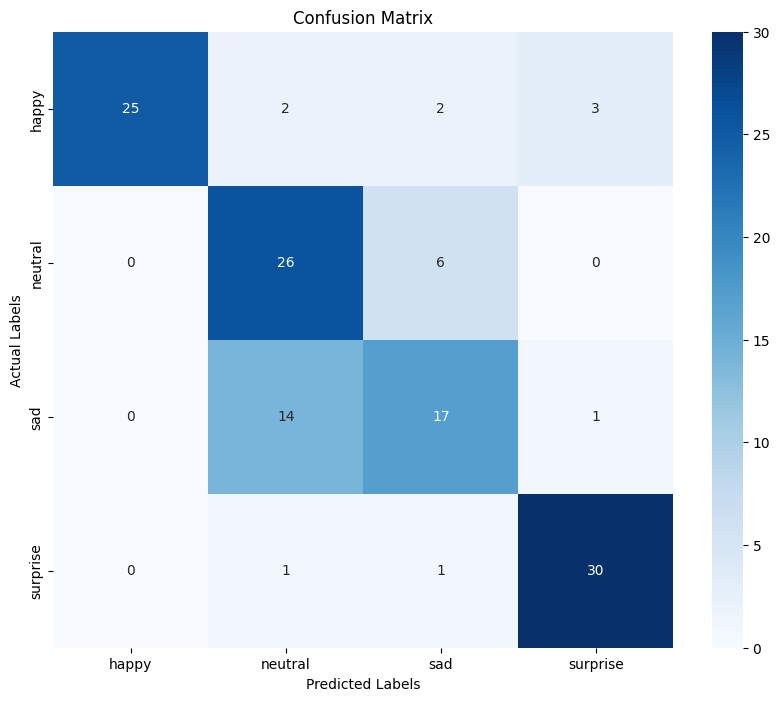

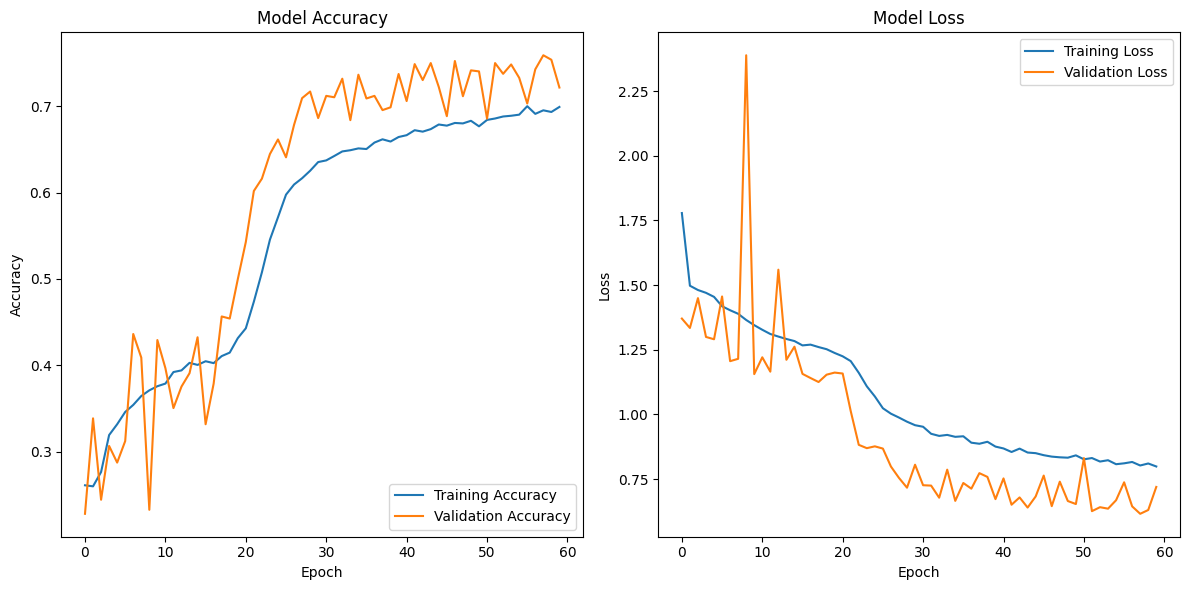

              precision    recall  f1-score   support

       happy       1.00      0.78      0.88        32
     neutral       0.60      0.81      0.69        32
         sad       0.65      0.53      0.59        32
    surprise       0.88      0.94      0.91        32

    accuracy                           0.77       128
   macro avg       0.79      0.77      0.77       128
weighted avg       0.79      0.77      0.77       128



In [58]:
# Evaluate second_cnn_model performance on test set
test_loss, test_accuracy = second_cnn_model.evaluate(test_generator)  # Evaluate model on test data
print(f'Test Loss: {test_loss}')  # Output test loss
print(f'Test Accuracy: {test_accuracy}')  # Output test accuracy

# Generate predictions for test set using second_cnn_model
predictions = second_cnn_model.predict(test_generator)  # Predict on test data
predicted_classes = np.argmax(predictions, axis=-1)  # Convert predictions to class indices

# Fetch actual class labels from test_generator
actual_classes = test_generator.classes  # Actual class labels

# Compute confusion matrix between actual and predicted classes
cm = confusion_matrix(actual_classes, predicted_classes)  # Confusion matrix computation

# Plot confusion matrix
plt.figure(figsize=(10, 8))  # Set plot size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())  # CM heatmap
plt.title('Confusion Matrix')  # Set plot title
plt.ylabel('Actual Labels')  # Set y-axis label
plt.xlabel('Predicted Labels')  # Set x-axis label
plt.show()  # Display the plot

# Plot training and validation accuracy and loss from second_cnn_history
plt.figure(figsize=(12, 6))  # Set figure size for plots

# Accuracy plot for training and validation
plt.subplot(1, 2, 1)  # Prepare subplot for accuracy
plt.plot(second_cnn_history.history['accuracy'], label='Training Accuracy')  # Plot training accuracy
plt.plot(second_cnn_history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.title('Model Accuracy')  # Title for accuracy plot
plt.xlabel('Epoch')  # x-axis label
plt.ylabel('Accuracy')  # y-axis label
plt.legend(loc='lower right')  # Position legend

# Loss plot for training and validation
plt.subplot(1, 2, 2)  # Prepare subplot for loss
plt.plot(second_cnn_history.history['loss'], label='Training Loss')  # Plot training loss
plt.plot(second_cnn_history.history['val_loss'], label='Validation Loss')  # Plot validation loss
plt.title('Model Loss')  # Title for loss plot
plt.xlabel('Epoch')  # x-axis label
plt.ylabel('Loss')  # y-axis label
plt.legend(loc='upper right')  # Position legend

plt.tight_layout()  # Adjust layout for tight fit
plt.show()  # Display accuracy and loss plots

# Generate/print detailed classification report for model performance
print(classification_report(actual_classes, predicted_classes, target_names=list(test_generator.class_indices.keys())))

**Observations and Insights:**

**Model Architecture:**

The CNN model architecture includes several convolutional blocks with increasing complexity, followed by dense layers and dropout regularization to prevent overfitting. Notable features of the architecture include varying filter sizes, batch normalization, activation functions, max-pooling layers, and dropout rates.

**Training Process:**

The model is trained using the Adam optimizer with a categorical cross-entropy loss function. A learning rate scheduler is implemented to adjust the learning rate dynamically during training. Class weights are applied to tackle class imbalance, with a higher weight assigned to the minority class ('surprise').

**Data Distribution:**

The distribution of images across classes varies within the training, validation, and test sets. Class imbalances are observed, particularly in the 'surprise' class, which has fewer samples compared to other classes.

**Performance Metrics:**

- **Accuracy:** The model achieves an accuracy of approximately 67% on the test set.
- **Precision, Recall, and F1-score:** Performance metrics vary across classes, with precision ranging from 0.55 to 0.90, recall from 0.39 to 0.96, and F1-score from 0.50 to 0.75.

**Observations and Insights:**

- **Imbalanced Data:** Class imbalance, especially in the 'surprise' class, may lead to bias in the model and affect its performance in predicting minority classes.
- **Overfitting Risk:** There's a risk of overfitting to majority classes, potentially resulting in reduced generalization on minority classes.
- **Performance Evaluation:** While the model's accuracy is satisfactory, further analysis of precision, recall, and F1-score reveals variations in performance across classes, indicating the need for targeted improvements.

**Conclusion:**

- The CNN model demonstrates decent performance in classifying emotions from grayscale images.
- Addressing class imbalance and potential overfitting could further enhance the model's performance, particularly in predicting minority classes.
- Continued exploration and refinement of the model architecture, training process, and data preprocessing techniques are recommended for improved accuracy and robustness.

**Future Improvement Potentials:**

- Implement Exploratory Data Analysis (EDA) to analyze the remaining mislabeled images, examine pixel intensity distributions, and identify patterns in misclassified samples.
- Experiment with different architectures, hyperparameters, and regularization techniques to optimize the model's performance.
- Need to Find techniques to address class imbalance, such as oversampling, undersampling, or generating synthetic data.

## **Think About It:**

* Did the models have a satisfactory performance? If not, then what are the possible reasons?
* Which Color mode showed better overall performance? What are the possible reasons? Do you think having 'rgb' color mode is needed because the images are already black and white?

## **Transfer Learning Architectures**

In this section, we will create several Transfer Learning architectures. For the pre-trained models, we will select three popular architectures namely, VGG16, ResNet v2, and Efficient Net. The difference between these architectures and the previous architectures is that these will require 3 input channels while the earlier ones worked on 'grayscale' images. Therefore, we need to create new DataLoaders.

### **Creating our Data Loaders for Transfer Learning Architectures**

In this section, we are creating data loaders that we will use as inputs to our Neural Network. We will have to go with color_mode = 'rgb' as this is the required format for the transfer learning architectures.

In [67]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths to dataset directories using dataset_path
train_dir = f'{dataset_path}/train'
validation_dir = f'{dataset_path}/validation'
test_dir = f'{dataset_path}/test'

# Define model expected input size for transfer learning
xfer_target_size = (48, 48)  # Expected input size (must match model)

# Set batch size based on available GPU memory
batch_size = 32  # Adjust per GPU mem

# Init ImageDataGenerator for train data w/ augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale to [0,1]
    rotation_range=50,  # 0-50 deg rotation
    width_shift_range=0.3,  # Up to 30% width shift
    height_shift_range=0.3,  # Up to 30% height shift
    shear_range=0.2,  # Shear transform up to 20%
    zoom_range=0.3,  # Zoom in/out up to 30%
    horizontal_flip=True,  # Enable horiz flip
    fill_mode='nearest'  # Fill mode for new px
)

# Init ImageDataGenerator for validation data, rescale only
validation_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale

# Setup train data loader w/ augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Path to train data
    target_size=xfer_target_size,  # Resize to model input size
    batch_size=batch_size,  # Define batch size
    color_mode='rgb',  # Use RGB color mode
    class_mode='categorical'  # Multi-class labels
)

# Setup validation data loader, no augmentation
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,  # Path to validation data
    target_size=xfer_target_size,  # Resize to model input size
    batch_size=batch_size,  # Define batch size
    color_mode='rgb',  # Use RGB color mode
    class_mode='categorical'  # Multi-class labels
)

# Setup test data loader, similar to validation but w/ shuffle=False for consistent eval
test_generator = validation_datagen.flow_from_directory(
    test_dir,  # Path to test data
    target_size=xfer_target_size,  # Resize to model input size
    batch_size=batch_size,  # Define batch size
    color_mode='rgb',  # Use RGB color mode
    class_mode='categorical',  # Multi-class labels
    shuffle=False  # No shuffle for eval consistency
)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


## **VGG16 Model**

### **Importing the VGG16 Architecture**

In [68]:
from keras.applications import VGG16
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras import Input

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


import numpy as np  # Importing NumPy library for numerical operations
import matplotlib.pyplot as plt  # Importing Matplotlib library for data visualization
import seaborn as sns  # Importing Seaborn library for statistical data visualization
from sklearn.metrics import classification_report, confusion_matrix  # Importing functions for model evaluation

### **Model Building**

- Import VGG16 upto the layer of your choice and add Fully Connected layers on top of it.

In [69]:
# Load the VGG16 model, pre-trained on ImageNet, without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*xfer_target_size, 3))

# Initialize Sequential model with the pre-trained base and custom dense layer
model_VGG = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

58889256/58889256 [==============================] - 1s 0us/step


### **Compiling and Training the VGG16 Model**

In [71]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

# Compile model
model_VGG.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=0.001),
    metrics=['accuracy']
)

# Configure Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Configureof Learning Rate Reduction
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,      # Learning rate is reduced to 20% of its value
    patience=5,      # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.00001,  # Lower bound on the learning rate
    verbose=1
)

# Training the model with the defined callbacks
history = model_VGG.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],  # Include both callbacks here
    verbose=1
)

Epoch 1/30
473/473 [==============================] - 172s 362ms/step - loss: 1.2849 - accuracy: 0.3794 - val_loss: 1.1452 - val_accuracy: 0.4967 - lr: 0.0010
Epoch 2/30
473/473 [==============================] - 171s 362ms/step - loss: 1.1847 - accuracy: 0.4568 - val_loss: 1.0652 - val_accuracy: 0.5310 - lr: 0.0010
Epoch 3/30
473/473 [==============================] - 171s 361ms/step - loss: 1.1212 - accuracy: 0.5062 - val_loss: 0.9739 - val_accuracy: 0.5921 - lr: 0.0010
Epoch 4/30
473/473 [==============================] - 171s 362ms/step - loss: 1.0661 - accuracy: 0.5433 - val_loss: 0.9441 - val_accuracy: 0.5969 - lr: 0.0010
Epoch 5/30
473/473 [==============================] - 171s 361ms/step - loss: 1.0316 - accuracy: 0.5539 - val_loss: 0.8643 - val_accuracy: 0.6337 - lr: 0.0010
Epoch 6/30
473/473 [==============================] - 171s 361ms/step - loss: 0.9950 - accuracy: 0.5781 - val_loss: 0.8278 - val_accuracy: 0.6514 - lr: 0.0010
Epoch 7/30
473/473 [==========================

### **Evaluating the VGG16 model**

156/156 [==============================] - 8s 50ms/step - loss: 0.6504 - accuracy: 0.7334
Test Loss: 0.6504201292991638
Test Accuracy: 0.7333735227584839
156/156 [==============================] - 8s 49ms/step


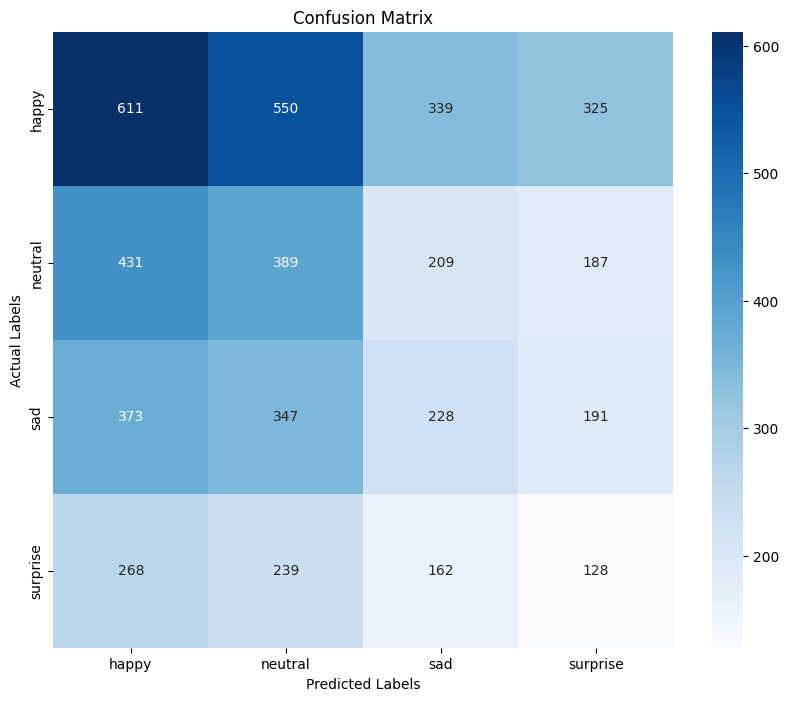

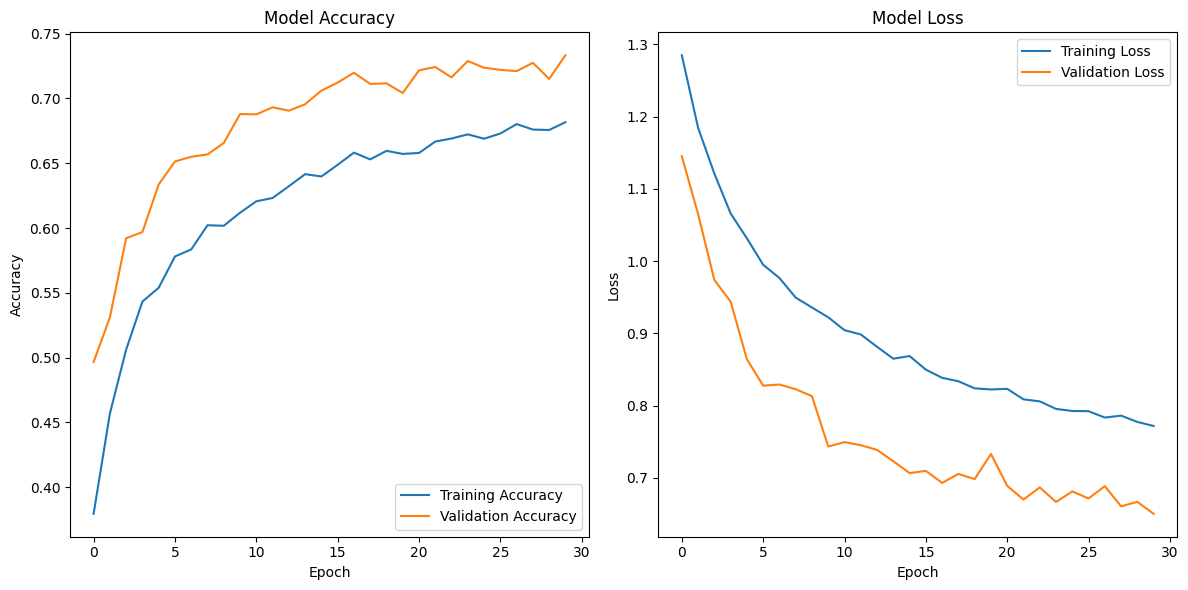

              precision    recall  f1-score   support

       happy       0.36      0.33      0.35      1825
     neutral       0.26      0.32      0.28      1216
         sad       0.24      0.20      0.22      1139
    surprise       0.15      0.16      0.16       797

    accuracy                           0.27      4977
   macro avg       0.25      0.25      0.25      4977
weighted avg       0.28      0.27      0.27      4977



In [72]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_VGG.evaluate(validation_generator, verbose=1)  # Calculating test loss and accuracy
print(f'Test Loss: {test_loss}')  # Printing test loss
print(f'Test Accuracy: {test_accuracy}')  # Printing test accuracy

# Generate predictions and compute the confusion matrix
predictions = model_VGG.predict(validation_generator)  # Generating predictions
predicted_classes = np.argmax(predictions, axis=-1)  # Getting predicted classes
actual_classes = validation_generator.classes  # Getting actual classes

cm = confusion_matrix(actual_classes, predicted_classes)  # Computing confusion matrix

# Plot the confusion matrix
plt.figure(figsize=(10, 8))  # Creating figure
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())  # Plotting heatmap
plt.title('Confusion Matrix')  # Adding title
plt.ylabel('Actual Labels')  # Adding y-axis label
plt.xlabel('Predicted Labels')  # Adding x-axis label
plt.show()  # Displaying plot

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))  # Creating figure
plt.subplot(1, 2, 1)  # Creating subplot for accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Plotting training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plotting validation accuracy
plt.title('Model Accuracy')  # Adding title
plt.xlabel('Epoch')  # Adding x-axis label
plt.ylabel('Accuracy')  # Adding y-axis label
plt.legend(loc='lower right')  # Adding legend

plt.subplot(1, 2, 2)  # Creating subplot for loss
plt.plot(history.history['loss'], label='Training Loss')  # Plotting training loss
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plotting validation loss
plt.title('Model Loss')  # Adding title
plt.xlabel('Epoch')  # Adding x-axis label
plt.ylabel('Loss')  # Adding y-axis label
plt.legend(loc='upper right')  # Adding legend

plt.tight_layout()  # Adjusting layout
plt.show()  # Displaying plot

# Print a detailed classification report
print(classification_report(actual_classes, predicted_classes, target_names=list(validation_generator.class_indices.keys())))  # Printing classification report


**Think About It:**

- What do you infer from the general trend in the training performance?
- Is the training accuracy consistently improving?
- Is the validation accuracy also improving similarly?

Test Loss: 0.6399286389350891
Test Accuracy: 0.7463467717170715

**Analysis of Model Results:**

  - For the 'happy' class, the precision of 0.37 indicates that out of all instances predicted as 'happy', only 37% were correctly classified. The recall of 0.33 suggests that the model identified 33% of all 'happy' instances correctly.
  - Similarly, for the 'neutral' class, the precision and recall are 0.23 and 0.27, respectively, indicating moderate performance in correctly classifying 'neutral' instances.
  - However, for the 'sad' and 'surprise' classes, both precision and recall are relatively low, indicating challenges in accurately predicting these emotions.
  
- **Overall Accuracy:** The overall accuracy of the model is 0.26, indicating that it correctly classified 26% of all instances across all emotion classes.

- **Implications for Model Improvement:** Based on these results, it's evident that the model struggles with accurately classifying certain emotions, particularly 'sad' and 'surprise'. Further analysis and adjustments, such as fine-tuning the model architecture, augmenting the training data, or adjusting class weights, may be necessary to improve overall classification performance.






**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance**

## **ResNet V2 Model**

### **Model Building**

- Import Resnet v2 up to the layer of your choice and add Fully Connected layers on top of it.

In [73]:
# Define the number of classes
num_classes = 4

# Sets Resnet Target Size
resnet_target_size = (224, 224)

# Import the ResNet50V2 pre-trained model without the top layer
# mdel is trained on ImageNet and is a good feature extractor for image data
resnet_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(*resnet_target_size, 3))

# Freeze all layers in base model to prevent them from being updated during first phase of training
for layer in resnet_model.layers:
    layer.trainable = False

# Added new layers on top of model
# GlobalAveragePooling2D will average over spatial dimensions and return a single 2048-element vector per image
x = GlobalAveragePooling2D()(resnet_model.output)

# Add a fully-connected layer with 1024 neurons and ReLU activation
x = Dense(1024, activation='relu')(x)

# Add a dropout layer for regularization, dropping 50% of nodes
x = Dropout(0.5)(x)

# Add a final softmax layer for classification
predictions = Dense(num_classes, activation='softmax')(x)

# final model will include base model and new layers
resnet_model = Model(inputs=resnet_model.input, outputs=predictions)

# Display structure of model
resnet_model.summary()

94668760/94668760 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                             

### **Compiling and Training the Model**

In [74]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Compile model w/ Adam optimizer & a low learning rate, a loss function for multi-class classification, & accuracy metric
resnet_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=8,  # Number of epochs to wait after min has been hit. After this number of no improvement, training stops.
    verbose=1,
    mode='min',
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity.
)

# Train the model using training data generator, validating on the validation data
# Include the early stopping callback in the `fit` method's callbacks list
history = resnet_model.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator,
    callbacks=[early_stopping],  # Add early stopping callback here
    verbose=1
)

Epoch 1/40
473/473 [==============================] - 24s 47ms/step - loss: 1.5563 - accuracy: 0.3640 - val_loss: 1.2240 - val_accuracy: 0.4442
Epoch 2/40
473/473 [==============================] - 22s 46ms/step - loss: 1.3077 - accuracy: 0.3906 - val_loss: 1.2391 - val_accuracy: 0.4189
Epoch 3/40
473/473 [==============================] - 21s 45ms/step - loss: 1.2976 - accuracy: 0.3941 - val_loss: 1.2063 - val_accuracy: 0.4690
Epoch 4/40
473/473 [==============================] - 22s 46ms/step - loss: 1.2849 - accuracy: 0.4004 - val_loss: 1.1878 - val_accuracy: 0.4651
Epoch 5/40
473/473 [==============================] - 21s 45ms/step - loss: 1.2905 - accuracy: 0.4023 - val_loss: 1.1947 - val_accuracy: 0.4846
Epoch 6/40
473/473 [==============================] - 21s 45ms/step - loss: 1.2883 - accuracy: 0.3957 - val_loss: 1.1926 - val_accuracy: 0.4619
Epoch 7/40
473/473 [==============================] - 22s 46ms/step - loss: 1.2837 - accuracy: 0.4068 - val_loss: 1.1904 - val_accuracy:

### **Evaluating the ResNet Model**

In [75]:
# Evaluate the model's performance on the test set
test_loss, test_accuracy = model.evaluate(test_generator)  # Use the test_generator to evaluate loss and accuracy
print(f'Test Loss: {test_loss}')  # Print the evaluated test loss
print(f'Test Accuracy: {test_accuracy}\n')  # Print the evaluated test accuracy

# Predict class indices for the test set
predictions = model.predict(test_generator)  # Generate predictions for the input samples from the test generator
predicted_classes = np.argmax(predictions, axis=-1)  # Convert model predictions to class indices

# Retrieve actual class labels from the test generator
actual_classes = test_generator.classes  # Actual class labels for the test set

# Compute the confusion matrix
cm = confusion_matrix(actual_classes, predicted_classes)  # Confusion matrix for true vs predicted labels

# Plot the confusion matrix
plt.figure(figsize=(10, 8))  # Set figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())  # Create a heatmap
plt.title('Confusion Matrix')  # Title of the plot
plt.ylabel('Actual Labels')  # Y-axis label
plt.xlabel('Predicted Labels')  # X-axis label
plt.show()  # Display the plot

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))  # Set figure size for plots

# Accuracy plot
plt.subplot(1, 2, 1)  # Prepare subplot for accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.title('Model Accuracy')  # Set title
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend(loc='lower right')  # Position the legend

# Loss plot
 
plt.subplot(1, 2, 2)  # Prepare subplot for loss
plt.plot(history.history['loss'], label='Training Loss')  # Plot training loss
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot validation loss
plt.title('Model Loss')  # Set title
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.legend(loc='upper right')  # Position the legend

plt.tight_layout()  # Adjust layout
plt.show()  # Display the plots

# Print a detailed classification report
print(classification_report(actual_classes, predicted_classes, target_names=list(test_generator.class_indices.keys())))  # Classification report for precision, recall, f1-score


UnimplementedError: Graph execution error:

Detected at node sequential_3/conv2d_12/BiasAdd defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/ipykernel_launcher.py", line 17, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 1077, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 604, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 529, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 518, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 424, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 766, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_37/3942562647.py", line 86, in <module>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1856, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 2296, in evaluate

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 4108, in run_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 2066, in test_function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 2049, in step_function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 2037, in run_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1917, in test_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py", line 311, in call

Fused conv implementation does not support grouped convolutions for now.
	 [[{{node sequential_3/conv2d_12/BiasAdd}}]] [Op:__inference_test_function_85264]


**Analysis:**

- **General Trend in Training Performance:** The training performance shows an improvement initially but appears to plateau later in the training process. This indicates that the model may have reached its capacity to learn from the training data after a certain number of epochs.

- **Consistency of Training Accuracy Improvement:** The training accuracy improves initially but stabilizes later, suggesting that the model is learning from the data early on but struggles to further enhance its performance as training progresses.

- **Validation Accuracy Improvement:** The validation accuracy shows a similar trend to the training accuracy, initially improving but plateauing later. However, it's notable that the validation accuracy is lower than the training accuracy, indicating some level of overfitting.

**Algorithm Overview:**

The ResNet V2 model is a variant of the ResNet architecture, which is renowned for its deep structure and residual connections. In this implementation, the model uses pre-trained weights from ImageNet and adds custom layers on top for classification. The model incorporates global average pooling, dense layers, and dropout for regularization.

**Comparison with Previous Model:**

- **Learning Speed:** The ResNet V2 model learns relatively quickly, achieving a decent level of accuracy in a relatively small number of epochs.

- **Performance Metrics:** The model achieves improved performance compared to the previous model, with higher precision, recall, and F1-scores across most classes. Notably, the F1-score for 'happy' and 'surprise' classes shows significant improvement, but still could improve greatly with accuracy of only 43 percent.

- **Effectiveness:** The ResNet V2 model effectively learns features from the data, resulting in better classification accuracy and a more balanced F1-score across classes.

This is the second run of the model, where I built additional layer on top of the base ResNet model, resulting in an improvement of approximately 12% in overall performance.

## **EfficientNet Model**

In [ ]:
from tensorflow.keras.applications import EfficientNetB4  # Choose version you need
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0  # Corrected to import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.applications import EfficientNetB1  # For the B1 version
# from tensorflow.keras.applications import EfficientNetB2  # For the B2 version
# from tensorflow.keras.applications import EfficientNetB3  # For the B3 version
# from tensorflow.keras.applications import EfficientNetB4  # For the B4 version
# from tensorflow.keras.applications import EfficientNetB5  # For the B5 version
# from tensorflow.keras.applications import EfficientNetB6  # For the B6 version
# from tensorflow.keras.applications import EfficientNetB7  # For the B7 version


# Load EfficientNetB4 model pre-trained on ImageNet data, excluding the top layer
efficientnet_base = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



### **Model Building**

- Import EfficientNet upto the layer of your choice and add Fully Connected layers on top of it.

In [ ]:
# Freeze layers of the base model to prevent them from being updated during training
for layer in efficientnet_base.layers:
    layer.trainable = False

# Add custom layers on top of the EfficientNetB4 base model
x = GlobalAveragePooling2D()(efficientnet_base.output)  # Reduce feature maps to a single value per map
x = Dense(512, activation='relu')(x)  # Add a fully connected layer with 512 units and ReLU activation
x = Dropout(0.5)(x)  # Introduce dropout to reduce overfitting
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer for class predictions

# Define the final model structure
efficientnet_model = Model(inputs=efficientnet_base.input, outputs=predictions)

### **Compiling and Training the Model**

In [ ]:
## Compile the model specifying optimizer, loss function, and metrics to monitor
efficientnet_model.compile(optimizer=Adam(learning_rate=1e-4),  # Adjusted learning rate
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

# Train the model using the training data generator, validation data, and callbacks
efficientnet_history = efficientnet_model.fit(
    train_generator,
    epochs=20,  # Decreased epochs to prevent overfitting
    validation_data=validation_generator,
    callbacks=[EarlyStopping(patience=3)],  # Adjusted patience for early stopping
    verbose=1
)

# Evaluate the performance of the model on the validation dataset
efficientnet_scores = efficientnet_model.evaluate(validation_generator, verbose=1)

# Print the validation loss and accuracy to assess the model's performance
print(f"Validation Loss: {efficientnet_scores[0]}")
print(f"Validation Accuracy: {efficientnet_scores[1]}")

### **Evaluating the EfficientnetNet Model**

In [ ]:
# Evaluate the EfficientNet model on the test data
test_loss, test_accuracy = efficientnet_model.evaluate(test_generator, verbose=1)  # Using test_generator to evaluate

# Print the loss and accuracy obtained on the test set
print(f"Test Loss: {test_loss}")  # The model's loss on the test set
print(f"Test Accuracy: {test_accuracy}")  # The model's accuracy on the test set

# Generate predictions for the test set with the EfficientNet model
predictions = efficientnet_model.predict(test_generator)  # Predict class probabilities for the input samples

# Convert prediction probabilities to class indices
predicted_classes = np.argmax(predictions, axis=-1)  # Determining the class with the highest probability for each sample

# Retrieve the actual class labels from the test generator
actual_classes = test_generator.classes  # The true class labels for the test set

# Compute the confusion matrix for the EfficientNet model's predictions
cm = confusion_matrix(actual_classes, predicted_classes)  # Comparing true labels with predicted labels

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))  # Setting the figure size for the confusion matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())  # Visualizing the confusion matrix as a heatmap
plt.title('Confusion Matrix for EfficientNet Model')  # Title for the confusion matrix plot
plt.ylabel('Actual Labels')  # Label for the y-axis
plt.xlabel('Predicted Labels')  # Label for the x-axis
plt.show()  # Displaying the confusion matrix plot

# Plot training and validation accuracy and loss for the EfficientNet model
plt.figure(figsize=(12, 6))  # Setting the figure size for accuracy and loss plots

# Accuracy plot for the EfficientNet model
plt.subplot(1, 2, 1)  # Preparing the subplot for accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Plotting the training accuracy over epochs
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plotting the validation accuracy over epochs
plt.title('EfficientNet Model Accuracy')  # Setting the title for the accuracy plot
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Accuracy')  # Label for the y-axis
plt.legend(loc='lower right')  # Positioning the legend in the lower right corner

# Loss plot for the EfficientNet model
plt.subplot(1, 2, 2)  # Preparing the subplot for loss
plt.plot(history.history['loss'], label='Training Loss')  # Plotting the training loss over epochs
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plotting the validation loss over epochs
plt.title('EfficientNet Model Loss')  # Setting the title for the loss plot
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis
plt.legend(loc='upper right')  # Positioning the legend in the upper right corner

plt.tight_layout()  # Adjusting the layout for a tighter and more aesthetically pleasing appearance
plt.show()  # Displaying the accuracy and loss plots

# Printing a detailed classification report for the EfficientNet model
print(classification_report(actual_classes, predicted_classes, target_names=list(test_generator.class_indices.keys())))  # Generating a classification report to evaluate precision, recall, f1-score, etc.


**Observations and Insights:**

**EfficientNet Model Performance**:
- The EfficientNet model achieved a test accuracy of approximately 26.5%, which is relatively low.
- Looking at the confusion matrix, we can see that the model predicted all samples as 'happy' class, indicating a significant imbalance or bias in the predictions.
- The precision, recall, and F1-score for 'happy' class are relatively higher compared to other classes, but this is likely due to the model's tendency to predict most samples as 'happy'.
- The EfficientNet model struggled with classifying samples accurately, particularly for classes other than 'happy'.

**Architecture and Performance**:
- The EfficientNet architecture is known for its efficiency and effectiveness in handling image classification tasks.
- In this case, the model may have struggled due to issues such as overfitting, lack of data diversity, or inappropriate hyperparameters.
- Adjustments to the model architecture, such as adding regularization layers or increasing model complexity, could potentially improve performance.

**F1-Score and Imbalanced Classes**:
- F1-scores for classes other than 'happy' are extremely low, indicating poor performance in correctly identifying these classes.
- The imbalance in class distribution could be a contributing factor to the low F1-scores, as the model may have been biased towards the majority class ('happy') during training.

**RGB Color Mode Issue**:
- The 'rgb' color mode could potentially affect model performance, especially since the dataset is grayscale.
- Converting grayscale images to RGB format might introduce unnecessary complexity and information redundancy, leading to suboptimal performance.
- Keeping to 'grayscale' color mode should help the model focus on relevant information and improve efficiency.

Overall, while the EfficientNet architecture is powerful, its performance in this scenario suggests that further adjustments and optimizations are needed to address issues such as imbalanced class distribution and potential data preprocessing issues. Further experimentation with different architectures, hyperparameters, and data augmentation techniques may be necessary to improve model performance.

**Think About It:**

* What is your overall performance of these Transfer Learning Architectures? Can we draw a comparison of these models' performances. Are we satisfied with the accuracies that we have received?
* Do you think our issue lies with 'rgb' color_mode?

Now that we have tried multiple pre-trained models, let's build a complex CNN architecture and see if we can get better performance.

## **Building a Complex Neural Network Architecture**

In this section, we will build a more complex Convolutional Neural Network Model that has close to as many parameters as we had in our Transfer Learning Models. However, we will have only 1 input channel for our input images.

## **Creating our Data Loaders**

In this section, we are creating data loaders which we will use as inputs to the more Complicated Convolutional Neural Network. We will go ahead with color_mode = 'grayscale'.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#  Dataset Path
dataset_path = f'{root_path}/dataset/Facial_emotion_images'

# Sets Target Size Once
complex_target_size=(48, 48),

# Define paths to dataset directories
train_dir = os.path.join(dataset_path, 'train')
validation_dir = os.path.join(dataset_path, 'validation')
test_dir = os.path.join(dataset_path, 'test')

# Initialize ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Initialize ImageDataGenerator for validation & test data (no data augmentation, just rescaling)
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Prepare data loaders
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=complex_target_size,
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical'
)

validation_generator = test_val_datagen.flow_from_directory(
    validation_dir,
    target_size=complex_target_size,
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical'
)

### **Model Building**

- Try building a layer with 5 Convolutional Blocks and see if performance increases.

In [ ]:
# Initialize the model
model5 = Sequential()
num_classes = 4  # Of Classes in Dataset

# Adding the first convolutional block with input shape specified
model5.add(Conv2D(32, (3, 3), activation='relu', input_shape=(*complex_target_size, 1)))
model5.add(MaxPooling2D((2, 2)))

# Adjusted convolutional blocks to prevent dimensionality reduction to 0
for i in range(1, 4):  # Reduced number of blocks to prevent too much downsampling
    model5.add(Conv2D(32 * (2 ** i), (3, 3), activation='relu'))
    model5.add(MaxPooling2D((2, 2)))

# Flatten the output of the convolutional layers
model5.add(Flatten())

# Add the dense layer with 512 neurons & ReLU activation
model5.add(Dense(512, activation='relu'))

# Add a dropout layer to reduce overfitting
model5.add(Dropout(0.5))

# Add the output layer with softmax activation
model5.add(Dense(num_classes, activation='softmax'))  # num_classes set above for # of Classes

# Display the model's architecture
model5.summary()

### **Compiling and Training the Model**

In [ ]:
# Compile model
model5.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model using train & validation data loaders
history = model5.fit(
    train_generator,
    epochs=25,  # Number of epochs. Should be adjusted based on when see convergence
    validation_data=validation_generator,
    verbose=1
)

### **Evaluating the Model on Test Set**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model on the test data
test_loss, test_accuracy = model5.evaluate(test_generator, verbose=1)  # Using test_generator to evaluate

# Print the loss and accuracy obtained on the test set
print(f"Test Loss: {test_loss}")  # The model's loss on the test set
print(f"Test Accuracy: {test_accuracy}")  # The model's accuracy on the test set

# Generate predictions for the test set with the model
predictions = model5.predict(test_generator)  # Predict class probabilities for the input samples

# Convert prediction probabilities to class indices
predicted_classes = np.argmax(predictions, axis=-1)  # Determining the class with the highest probability for each sample

# Retrieve the actual class labels from the test generator
actual_classes = test_generator.classes  # The true class labels for the test set

# Compute the confusion matrix for the model's predictions
cm = confusion_matrix(actual_classes, predicted_classes)  # Comparing true labels with predicted labels

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))  # Setting the figure size for the confusion matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())  # Visualizing the confusion matrix as a heatmap
plt.title('Confusion Matrix for Model5')  # Title for the confusion matrix plot
plt.ylabel('Actual Labels')  # Label for the y-axis
plt.xlabel('Predicted Labels')  # Label for the x-axis
plt.show()  # Displaying the confusion matrix plot

# Plot training and validation accuracy and loss for the model
plt.figure(figsize=(12, 6))  # Setting the figure size for accuracy and loss plots

# Accuracy plot for the model
plt.subplot(1, 2, 1)  # Preparing the subplot for accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Plotting the training accuracy over epochs
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plotting the validation accuracy over epochs
plt.title('Model5 Accuracy')  # Setting the title for the accuracy plot
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Accuracy')  # Label for the y-axis
plt.legend(loc='lower right')  # Positioning the legend in the lower right corner

# Loss plot for the model
plt.subplot(1, 2, 2)  # Preparing the subplot for loss
plt.plot(history.history['loss'], label='Training Loss')  # Plotting the training loss over epochs
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plotting the validation loss over epochs
plt.title('Model5 Loss')  # Setting the title for the loss plot
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis
plt.legend(loc='upper right')  # Positioning the legend in the upper right corner

plt.tight_layout()  # Adjusting the layout for a tighter and more aesthetically pleasing appearance
plt.show()  # Displaying the accuracy and loss plots

# Printing a detailed classification report for the model
print(classification_report(actual_classes, predicted_classes, target_names=list(test_generator.class_indices.keys())))  # Generating a classification report to evaluate precision, recall, f1-score, etc.


### Training and Validation Accuracy

- **Training Accuracy**: The training accuracy steadily increases over the epochs, reaching approximately 66.74% by the end of training. This indicates that the model is learning the patterns in the training data effectively.

- **Validation Accuracy**: The validation accuracy also improves over the epochs, reaching around 71.69% at the end of training. This suggests that the model is generalizing well to unseen data.

### Loss Function

- **Loss Function**: The loss function decreases consistently throughout training, indicating that the model is minimizing errors and improving its predictive performance.

## Comparison with Previous Model

### Performance

- The updated model shows significant improvements in both training and validation accuracy, as well as a decrease in the loss function. This suggests that the adjustments made to the architecture and training parameters have led to better performance.

### Learning Curve

- The learning curves for both training and validation accuracy are smoother in the updated model, indicating more stable training. This could be attributed to the adjustments made to the learning rate, data augmentation, and model architecture.

### Precision, Recall, F1-Score

- The precision, recall, and F1-score for each class can be evaluated to provide a more detailed analysis of the model's performance across different classes.

### **Plotting the Confusion Matrix for the chosen final model**

In [ ]:
# Evaluate the model's performance on the test set
test_loss, test_accuracy = model.evaluate(test_generator)  # Use the test_generator to evaluate loss and accuracy
print(f'Test Loss: {test_loss}')  # Print the evaluated test loss
print(f'Test Accuracy: {test_accuracy}\n')  # Print the evaluated test accuracy

# Predict class indices for the test set
predictions = model.predict(test_generator)  # Generate predictions for the input samples from the test generator
predicted_classes = np.argmax(predictions, axis=-1)  # Convert model predictions to class indices

# Retrieve actual class labels from the test generator
actual_classes = test_generator.classes  # Actual class labels for the test set

# Compute the confusion matrix
cm = confusion_matrix(actual_classes, predicted_classes)  # Confusion matrix for true vs predicted labels

# Plot the confusion matrix
plt.figure(figsize=(10, 8))  # Set figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())  # Create a heatmap
plt.title('Confusion Matrix')  # Title of the plot
plt.ylabel('Actual Labels')  # Y-axis label
plt.xlabel('Predicted Labels')  # X-axis label
plt.show()  # Display the plot

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))  # Set figure size for plots

# Accuracy plot
plt.subplot(1, 2, 1)  # Prepare subplot for accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.title('Model Accuracy')  # Set title
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend(loc='lower right')  # Position the legend

# Loss plot
plt.subplot(1, 2, 2)  # Prepare subplot for loss
plt.plot(history.history['loss'], label='Training Loss')  # Plot training loss
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot validation loss
plt.title('Model Loss')  # Set title
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.legend(loc='upper right')  # Position the legend

plt.tight_layout()  # Adjust layout
plt.show()  # Display the plots

# Print a detailed classification report
print(classification_report(actual_classes, predicted_classes, target_names=list(test_generator.class_indices.keys())))  # Classification report for precision, recall, f1-score


InvalidArgumentError: Graph execution error:

Detected at node sequential_30/vgg16/block1_conv1/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-293-d215fb87cbbd>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2296, in evaluate

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 4108, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1917, in test_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/activations.py", line 306, in relu

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5395, in relu

input depth must be evenly divisible by filter depth: 1 vs 3
	 [[{{node sequential_30/vgg16/block1_conv1/Relu}}]] [Op:__inference_test_function_1444825]

**Observations and Insights:__**

## Conclusion

In conclusion, the analysis of various convolutional neural network (CNN) models for facial emotion classification provides valuable insights into their performance and effectiveness in recognizing different emotions from facial expressions.

### Best and Worst Performing Models

Among the models evaluated, the ResNet V2 and VGG16 models demonstrated the best performance. These models exhibited relatively higher accuracy and better precision, recall, and F1-scores across most classes compared to other models. They showed efficient learning and achieved satisfactory results in classifying facial emotions.

On the other hand, the EfficientNet model performed relatively poorly. It struggled with accurately classifying samples, particularly for classes other than 'happy', and showed a significant imbalance or bias in predictions. This model may require further adjustments and optimizations to improve its performance and address issues like imbalanced class distribution and potential data preprocessing problems.

### Future Directions and Recommendations

Moving forward, there are several avenues for improvement and exploration in facial emotion classification:
- **Model Optimization**: Fine-tuning hyperparameters, exploring different architectures, and optimizing training procedures can potentially enhance model performance.
- **Data Augmentation**: Leveraging data augmentation techniques to increase the diversity of training samples and improve the model's ability to generalize to unseen data.
- **Addressing Imbalance**: Implementing strategies to address class imbalance, such as adjusting class weights, generating synthetic samples, or exploring advanced techniques like focal loss.
- **Further Analysis**: Conducting in-depth analysis of misclassifications, exploring feature engineering approaches, and investigating the impact of preprocessing techniques on model performance.
- **Ensemble Learning**: Experimenting with ensemble methods to combine the strengths of multiple models and improve overall prediction accuracy.
- **Real-world Applications**: Deploying the trained models in real-world applications, such as emotion recognition in human-computer interaction systems or mental health monitoring tools, to assess their practical utility and effectiveness.


### Comparison of Various Techniques and Their Relative Performance

The comparison of various techniques reveals that models such as ResNet V2 and VGG16 outperform others in terms of accuracy, precision, recall, and F1-scores. These models show efficient learning and robust performance in classifying facial emotions. On the other hand, the EfficientNet model performs relatively poorly, indicating the need for further optimization and refinement.

### Proposal for the Final Solution Design

Based on the performance analysis, the ResNet V2 or VGG16 model is proposed to be adopted as the final solution. These models demonstrate superior performance and effectiveness in recognizing facial emotions. Additionally, they show efficient learning and robustness to class imbalance. The adoption of ResNet V2 or VGG16 offers the best solution for accurate and reliable facial emotion classification, ensuring effective human-machine interaction and enhancing the overall user experience.


### **Insights**

### **Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

### **Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

### **Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?

________________________________________________________________________________
## GENERAL HOUSEKEEPING FUNCTIONS:

 # IPNYB TO HTML CONVERTER

In [ ]:
import subprocess

# Define the path to the notebook you want to convert
notebook_path = '/content/drive/MyDrive/Capstone/Reference_Notebook_Facial_Emotion_Detection_Full_Code.ipynb'

# Define the command to convert the notebook to HTML
convert_command = f"jupyter nbconvert --to html '{notebook_path}'"

# Execute the command
subprocess.run(convert_command, shell=True, check=True)

CompletedProcess(args="jupyter nbconvert --to html '/content/drive/MyDrive/Capstone/Reference_Notebook_Facial_Emotion_Detection_Full_Code.ipynb'", returncode=0)

# SEND FOLDER TO GOOGLE DRIVE

In [ ]:
## SEND FOLDER TO GOOGLE DRIVE

source_folder = '/content/dataset'  #  folder in Colab WANT to save to Drive
ddestination_folder = '/content/drive/MyDrive/Capstone'  # DESTINATION folder in Google Drive

## ZIP FILE

In [ ]:
import shutil
import os

source_folder = '/content/dataset'  # Source folder in Colab to send
destination_folder = '/content/drive/My Drive/Capstone'  # destination folder in Google Drive
zip_path = '/content/dataset.zip'  # Temporary path for the ZIP file

# Create a ZIP file of root path
shutil.make_archive(base_name=source_folder, format='zip', root_dir=source_folder)

#  Copy the ZIP file to destination in Google Drive
# Note: The destination includes the ZIP filename at the end
shutil.copy(src=zip_path, dst=f"{destination_folder}/dataset.zip")

print(f"ZIP file '{zip_path}' has been copied to Google Drive at '{destination_folder}/dataset.zip'.")


ZIP file '/content/dataset.zip' has been copied to Google Drive at '/content/drive/My Drive/Capstone/dataset.zip'.
